In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d68f1b495e79e0f52a5475e4a732ad6aef60ac2474f55542a0667eb348aa7335
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Download 100%.


In [ ]:
!signate download -c 1088

user.csv

card.csv

sample_submit.csv

test.csv

train.csv


Download completed.


In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight
from geopy.geocoders import Nominatim
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna


# 列の制限を増やす
pd.set_option('display.max_columns', 300)

In [ ]:
# データの読み込み
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
card_data = pd.read_csv('card.csv')
user_data = pd.read_csv('user.csv')

# データの結合
train_data = train_data.merge(card_data, on=['user_id', 'card_id'], how='left')
train_data = train_data.merge(user_data, on='user_id', how='left')

test_data = test_data.merge(card_data, on=['user_id', 'card_id'], how='left')
test_data = test_data.merge(user_data, on='user_id', how='left')

## データの前処理・特徴量エンジニアリング

In [ ]:
submit_id = 18

# 数値データ型に変換
numerical_columns = ['amount', 'credit_limit', 'per_capita_income_zipcode', 'yearly_income_person', 'total_debt']

for column in numerical_columns:
    train_data[column] = train_data[column].str.replace('$', '').str.replace(',', '').astype(float)
    test_data[column] = test_data[column].str.replace('$', '').str.replace(',', '').astype(float)


# --------------------------------------------------------------------------------
# merchant_state == NaN -> merchant_city == ONLINE
# zip == NaN -> merchant_city == ONLINE or アメリカ国外
# --------------------------------------------------------------------------------

# "is_online"と"is_foreign"カラムを0で初期化
train_data['is_online'] = 0
train_data['is_foreign'] = 0
test_data['is_online'] = 0
test_data['is_foreign'] = 0

# 条件に合致する行に対してフラグを設定
mask_online = (train_data['zip'].isna()) & (train_data['merchant_city'] == 'ONLINE')
mask_foreign = (train_data['zip'].isna()) & (train_data['merchant_city'] != 'ONLINE')

train_data.loc[mask_online, 'is_online'] = 1
train_data.loc[mask_foreign, 'is_foreign'] = 1

mask_online = (test_data['zip'].isna()) & (test_data['merchant_city'] == 'ONLINE')
mask_foreign = (test_data['zip'].isna()) & (test_data['merchant_city'] != 'ONLINE')

test_data.loc[mask_online, 'is_online'] = 1
test_data.loc[mask_foreign, 'is_foreign'] = 1


# 'birth_month'と'birth_year'を合わせた新しいカラムを追加（月を小数点以下の日数に変換）
train_data['birth_month_year'] = train_data['birth_year'] + (train_data['birth_month'] - 1) / 12
test_data['birth_month_year'] = test_data['birth_year'] + (test_data['birth_month'] - 1) / 12

# 'birth_month'と'birth_year'カラムを削除
train_data.drop(['birth_month', 'birth_year'], axis=1, inplace=True)
test_data.drop(['birth_month', 'birth_year'], axis=1, inplace=True)


# 'expires' カラムを月と年に分割して新しい特徴量として追加
train_data['expires_month'] = pd.to_datetime(train_data['expires'], format='%m/%Y').dt.month
train_data['expires_year'] = pd.to_datetime(train_data['expires'], format='%m/%Y').dt.year

test_data['expires_month'] = pd.to_datetime(test_data['expires'], format='%m/%Y').dt.month
test_data['expires_year'] = pd.to_datetime(test_data['expires'], format='%m/%Y').dt.year

# 'expires_month'と'expires_year'を合わせた新しいカラムを生成（月を小数点以下の日数に変換）
train_data['expires_month_year'] = train_data['expires_year'] + (train_data['expires_month'] - 1) / 12
test_data['expires_month_year'] = test_data['expires_year'] + (test_data['expires_month'] - 1) / 12

# 'expires', 'expires_month', 'expires_year' カラムを削除
train_data.drop(['expires'], axis=1, inplace=True)
test_data.drop(['expires'], axis=1, inplace=True)

train_data.drop(['expires_month'], axis=1, inplace=True)
test_data.drop(['expires_month'], axis=1, inplace=True)

train_data.drop(['expires_year'], axis=1, inplace=True)
test_data.drop(['expires_year'], axis=1, inplace=True)


# 'acct_open_date' カラムを年と月に分割して新しい特徴量として追加
train_data['acct_open_month'] = pd.to_datetime(train_data['acct_open_date']).dt.month
train_data['acct_open_year'] = pd.to_datetime(train_data['acct_open_date']).dt.year

test_data['acct_open_month'] = pd.to_datetime(test_data['acct_open_date']).dt.month
test_data['acct_open_year'] = pd.to_datetime(test_data['acct_open_date']).dt.year

# 'acct_open_month'と'acct_open_year'を合わせた新しいカラムを生成（月を小数点以下の日数に変換）
train_data['acct_open_month_year'] = train_data['acct_open_year'] + (train_data['acct_open_month'] - 1) / 12
test_data['acct_open_month_year'] = test_data['acct_open_year'] + (test_data['acct_open_month'] - 1) / 12

# 'acct_open_date', 'acct_open_month', 'acct_open_year'カラムを削除
train_data.drop(['acct_open_date', 'acct_open_month', 'acct_open_year'], axis=1, inplace=True)
test_data.drop(['acct_open_date', 'acct_open_month', 'acct_open_year'], axis=1, inplace=True)


# 'expires_month_year'と'acct_open_month_year'の差を計算して新しいカラムを生成
# train_data['expires_open_month_year_diff'] = train_data['expires_month_year'] - train_data['acct_open_month_year']
# test_data['expires_open_month_year_diff'] = test_data['expires_month_year'] - test_data['acct_open_month_year']


# 'card_id'と'num_credit_cards'の割り算をした新しいカラムを追加
train_data['card_id_divided_by_num_credit_cards'] = train_data['card_id'] / train_data['num_credit_cards']
test_data['card_id_divided_by_num_credit_cards'] = test_data['card_id'] / test_data['num_credit_cards']

# 'card_id_divided_by_num_credit_cards' カラムを numerical_columns に追加
numerical_columns.append('card_id_divided_by_num_credit_cards')


# 'user_id'と'card_id'を結合して新しいカテゴリカルデータを生成
train_data['user_card_combined'] = train_data['user_id'].astype(str) + '_' + train_data['card_id'].astype(str)
test_data['user_card_combined'] = test_data['user_id'].astype(str) + '_' + test_data['card_id'].astype(str)


# 'user_id' カラムを削除
train_data.drop('user_id', axis=1, inplace=True)
test_data.drop('user_id', axis=1, inplace=True)

# 'card_id' カラムを削除
train_data.drop('card_id', axis=1, inplace=True)
test_data.drop('card_id', axis=1, inplace=True)


# 'index' カラムを削除
test_data_index = test_data['index']
train_data.drop(['index'], axis=1, inplace=True)
test_data.drop(['index'], axis=1, inplace=True)

# 'address' カラムを削除
train_data.drop(['address'], axis=1, inplace=True)
test_data.drop(['address'], axis=1, inplace=True)


<ipython-input-27-e40865c40179>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_data[column] = train_data[column].str.replace('$', '').str.replace(',', '').astype(float)
<ipython-input-27-e40865c40179>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_data[column] = test_data[column].str.replace('$', '').str.replace(',', '').astype(float)


## ラグ特徴量のエンジニアリング

In [ ]:
# ラグ特徴量の数（過去何回分のデータを使うか）を指定
lag_window = 100

# ラグ特徴量を導入するカラムのリスト
lag_columns = ['amount', 'merchant_id']

# ラグ特徴量を計算し、新しいカラムとして追加
for lag in range(1, lag_window + 1):
    for column in lag_columns:
        lag_feature_name = f"{column}_lag{lag}"

        # train_dataとtest_dataを結合してラグ特徴量を生成
        combined_data = pd.concat([train_data, test_data], axis=0)
        combined_data[lag_feature_name] = combined_data.groupby('user_card_combined')[column].shift(lag)

        # 分割して元のtrain_dataとtest_dataに戻す
        train_data = combined_data.iloc[:len(train_data), :]
        test_data = combined_data.iloc[len(train_data):, :]

test_data.drop(['is_fraud?'], axis=1, inplace=True)


<ipython-input-28-7c1b45b0c5d6>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data[lag_feature_name] = combined_data.groupby('user_card_combined')[column].shift(lag)
<ipython-input-28-7c1b45b0c5d6>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data[lag_feature_name] = combined_data.groupby('user_card_combined')[column].shift(lag)
<ipython-input-28-7c1b45b0c5d6>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

## is_fraud? の index による変化

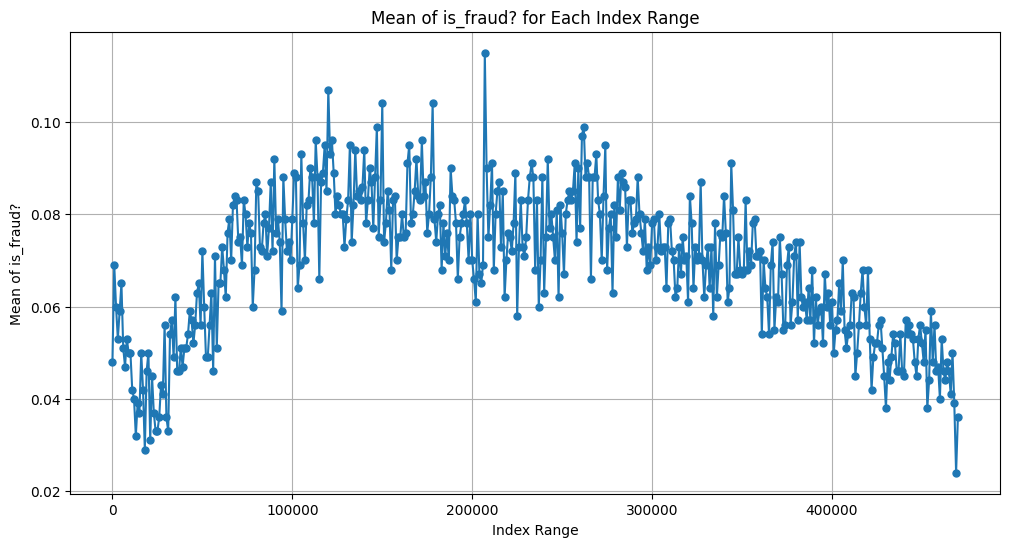

In [ ]:
# "index"の範囲ごとにデータを分割し、"is_fraud?"の平均値を計算
index_ranges = range(0, len(train_data), 1000)  # 1000ごとに範囲を分割（適宜調整）
fraud_means = []

for i in range(len(index_ranges) - 1):
    start_index = index_ranges[i]
    end_index = index_ranges[i + 1]
    subset = train_data[start_index:end_index]
    fraud_mean = subset['is_fraud?'].mean()
    fraud_means.append(fraud_mean)

# "index"の範囲ごとの平均値をプロット
plt.figure(figsize=(12, 6))
plt.plot(index_ranges[:-1], fraud_means, marker='o', linestyle='-', markersize=5)
plt.xlabel('Index Range')
plt.ylabel('Mean of is_fraud?')
plt.title('Mean of is_fraud? for Each Index Range')
plt.grid(True)
plt.show()


## merchant_state == NaN -> merchant_city == ONLINE

In [ ]:
# "merchant_state"がNaNのデータをフィルタリング
filtered_data = train_data[train_data['merchant_state'].isna()]

# "merchant_city"カラムの異なる値を取得
unique_merchant_cities = filtered_data['merchant_city'].unique()

# 異なる値を表示
print(unique_merchant_cities)


['ONLINE']
Categories (4396, object): ['Abbeville', 'Abilene', 'Abingdon', 'Abita Springs', ..., 'Zionsville',
                            'Zuni', 'Zurich', 'Zwolle']


## zip == NaN -> merchant_city == ONLINE or アメリカ国外

In [ ]:
# "zip"がNaNのデータをフィルタリング
filtered_data = train_data[train_data['zip'].isna()]

# "merchant_city"カラムの異なる値を取得
unique_merchant_cities = filtered_data['merchant_city'].unique()

# 異なる値を表示
print(unique_merchant_cities)


['Rio de Janeiro', 'ONLINE', 'Rome', 'Calgary', 'Algiers', ..., 'Muscat', 'Lisbon', 'Sao Paolo', 'Andorra La Vella', 'Moroni']
Length: 83
Categories (4396, object): ['Abbeville', 'Abilene', 'Abingdon', 'Abita Springs', ..., 'Zionsville',
                            'Zuni', 'Zurich', 'Zwolle']


In [ ]:
# isna()またはisnull()メソッドを使用して欠損値を検出
# これは各セルが欠損値の場合、Trueを返し、それ以外の場合はFalseを返します
has_nan = train_data.isna().any()

# 各カラムごとにNaNが存在するかどうかを確認
for column, has_nan_value in has_nan.iteritems():
    if has_nan_value:
        print(f"カラム '{column}' にNaNが存在します。")

# または、欠損値の総数をカウントすることもできます
total_nan_count = train_data.isna().sum().sum()
print(f"総欠損値の数: {total_nan_count}")

カラム 'merchant_state' にNaNが存在します。
カラム 'zip' にNaNが存在します。
総欠損値の数: 149908


<ipython-input-11-fdadd89d5b97>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, has_nan_value in has_nan.iteritems():


#lightGBM

## 訓練データと検証データに分割・特徴量エンジニアリング

In [ ]:
# 特徴量とターゲットの分割
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 各ホールドで特徴量の値が異なるので、test_data をコピー
test_data_copy = test_data.copy()


# 'user_card_combined' ごとの is_fraud? の平均値を計算し、新しいカラムを追加 （y_train を使用）
X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
test_data_copy['user_card_combined_mean_fraud'] = test_data_copy['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())


# 'user_card_combined' ごとに 'is_fraud?' が 1 の場合の 'amount' の平均を計算
fraud_indices = y_train[y_train == 1].index
fraud_amount_mean = X_train.loc[fraud_indices].groupby('user_card_combined')['amount'].mean().reset_index()
fraud_amount_mean.columns = ['user_card_combined', 'fraud_amount_mean']

# 'user_card_combined' ごとの 'amount' の平均を追加 （y_train を使用）
X_train = X_train.merge(fraud_amount_mean, on='user_card_combined', how='left')
X_val = X_val.merge(fraud_amount_mean, on='user_card_combined', how='left')
test_data_copy = test_data_copy.merge(fraud_amount_mean, on='user_card_combined', how='left')

# 'user_card_combined' カラムを削除
X_train.drop(['user_card_combined'], axis=1, inplace=True)
X_val.drop(['user_card_combined'], axis=1, inplace=True)
test_data_copy.drop(['user_card_combined'], axis=1, inplace=True)

# 'fraud_amount_mean' カラムを削除
X_train.drop(['fraud_amount_mean'], axis=1, inplace=True)
X_val.drop(['fraud_amount_mean'], axis=1, inplace=True)
test_data_copy.drop(['fraud_amount_mean'], axis=1, inplace=True)


# 'merchant_city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
X_train['fraud_mean_by_merchant_city'] = X_train['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
X_val['fraud_mean_by_merchant_city'] = X_val['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
test_data_copy['fraud_mean_by_merchant_city'] = test_data_copy['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())

# 'merchant_city' カラムを削除
X_train.drop(['merchant_city'], axis=1, inplace=True)
X_val.drop(['merchant_city'], axis=1, inplace=True)
test_data_copy.drop(['merchant_city'], axis=1, inplace=True)


# 'merchant_id' ごとに 'is_fraud?' の平均値を計算したDataFrameを作成
fraud_mean_by_merchant_id = y_train.groupby(X_train['merchant_id']).mean().reset_index()
fraud_mean_by_merchant_id.columns = ['merchant_id', 'fraud_mean_by_merchant_id']

# X_train に 'merchant_id' ごとの詐欺平均値をマージ
X_train = X_train.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

# X_val に 'merchant_id' ごとの詐欺平均値をマージ
X_val = X_val.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

# test_data に 'merchant_id' ごとの詐欺平均値をマージ
test_data_copy = test_data_copy.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')


# ラグ特徴量に対応する 'fraud_mean' カラムを追加
for lag in range(1, lag_window + 1):
    merchant_id_lag_col = f'merchant_id_lag{lag}'
    new_col_name = 'fraud_mean_by_' + merchant_id_lag_col

    # 'merchant_id' と 'fraud_mean_by_merchant_id' の対応付け
    X_train[new_col_name] = X_train[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
    X_val[new_col_name] = X_val[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
    test_data_copy[new_col_name] = test_data_copy[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])

    # merchant_id_lag_col カラムを削除
    X_train.drop([merchant_id_lag_col], axis=1, inplace=True)
    X_val.drop([merchant_id_lag_col], axis=1, inplace=True)
    test_data_copy.drop([merchant_id_lag_col], axis=1, inplace=True)


# 'merchant_id' カラムを削除
X_train.drop(['merchant_id'], axis=1, inplace=True)
X_val.drop(['merchant_id'], axis=1, inplace=True)
test_data_copy.drop(['merchant_id'], axis=1, inplace=True)


# 'city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
X_train['fraud_mean_by_city'] = X_train['city'].map(y_train.groupby(X_train['city']).mean())
X_val['fraud_mean_by_city'] = X_val['city'].map(y_train.groupby(X_train['city']).mean())
test_data_copy['fraud_mean_by_city'] = test_data_copy['city'].map(y_train.groupby(X_train['city']).mean())

# 'city' カラムを削除
X_train.drop(['city'], axis=1, inplace=True)
X_val.drop(['city'], axis=1, inplace=True)
test_data_copy.drop(['city'], axis=1, inplace=True)

# 数値データを float, カテゴリカルデータを category に変換
cat_cols = ['errors?', 'merchant_state', 'zip', 'mcc', 'use_chip', 'card_brand', 'card_type', 'has_chip', 'gender', 'state', 'zipcode', 'is_online', 'is_foreign']
# train_data.columnsからcat_colsに含まれないカラムを抽出してnum_colsに格納
num_cols = [col for col in X_train.columns if col not in cat_cols]

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_val[cat_cols] = X_val[cat_cols].astype('category')
test_data_copy[cat_cols] = test_data_copy[cat_cols].astype('category')

X_train[num_cols] = X_train[num_cols].astype('float')
X_val[num_cols] = X_val[num_cols].astype('float')
test_data_copy[num_cols] = test_data_copy[num_cols].astype('float')

<ipython-input-8-04fb907b5bd3>:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[new_col_name] = X_train[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
<ipython-input-8-04fb907b5bd3>:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_val[new_col_name] = X_val[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
<ipython-input-8-04fb907b5bd3>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usua

## optuna によるハイパーパラメータチューニング

In [ ]:
def f1_eval(preds, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    f1 = f1_score(y_true, y_pred)
    return 'f1_score', f1, True

In [ ]:
def objective(trial):
    # ハイパーパラメータのサーチスペースを定義
    # params = {
    #     'boosting_type': 'gbdt',
    #     'metric': 'binary_logloss',
    #     'verbose': 1,
    #     'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
    #     'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
    #     'objective': 'binary',
    #     'num_leaves': trial.suggest_int('num_leaves', 7, 31),
    #     'seed': 42,
    #     'max_depth': trial.suggest_int('max_depth', 5, 9),
    #     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
    #     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 0.9),
    #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
    #     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.9, 1.0),
    #     # 他のハイパーパラメータもここに追加
    # }

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'None',

        'lambda_l1'         : trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2'         : trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),

        'force_col_wise':True,
        'random_state': 0,
        }

    # サンプルウェイトの計算
    train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
    train_dataset = lgb.Dataset(X_train, label=y_train, weight=train_weight)
    val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)


    # callbacks = [lgb.log_evaluation(1)]  # コマンドライン出力用コールバック関数
    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数

    # モデルの学習
    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset], num_boost_round=100, feval=f1_eval, callbacks=callbacks)

    # 検証データに対する予測
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

    # F1スコアの計算（最大化したい指標）
    f1 = f1_score(y_val, val_pred_binary)

    return f1

# Optunaのスタディの作成
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # n_trialsは試行回数

# 最適なハイパーパラメータの表示
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2023-09-11 17:37:57,330] A new study created in memory with name: no-name-3e8baf6d-2374-413e-819d-8f2dea549cda


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.381059	valid_1's f1_score: 0.366311
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.412386	valid_1's f1_score: 0.396478
[3]	training's f1_score: 0.417983	valid_1's f1_score: 0.402751
[4]	training's f1_score: 0.430739	valid_1's f1_score: 0.413614
[5]	training's f1_score: 0.441663	valid_1's f1_score: 0.420828
[6]	training's f1_score: 0.442379	valid_1's f1_score: 0.4

[I 2023-09-11 17:39:16,172] Trial 0 finished with value: 0.5126744835287548 and parameters: {'lambda_l1': 0.030008511606185447, 'lambda_l2': 3.355414803422563e-07, 'learning_rate': 0.2506700506596002, 'num_leaves': 98, 'feature_fraction': 0.6166125513696823, 'bagging_fraction': 0.49405174075647135, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 0 with value: 0.5126744835287548.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.375401	valid_1's f1_score: 0.360273
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.408755	valid_1's f1_score: 0.392856
[3]	training's f1_score: 0.417711	valid_1's f1_score: 0.401793
[4]	training's f1_score: 0.429974	valid_1's f1_score: 0.414524
[5]	training's f1_score: 0.441726	valid_1's f1_score: 0.423271
[6]	training's f1_score: 0.440855	valid_1's f1_score: 0.4

[I 2023-09-11 17:40:28,543] Trial 1 finished with value: 0.4806912175333229 and parameters: {'lambda_l1': 3.630708935205503e-07, 'lambda_l2': 3.2644967614256823, 'learning_rate': 0.5403060131006355, 'num_leaves': 48, 'feature_fraction': 0.5655371313867006, 'bagging_fraction': 0.5579555603232095, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 0 with value: 0.5126744835287548.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.214113	valid_1's f1_score: 0.212935
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.299468	valid_1's f1_score: 0.295649
[3]	training's f1_score: 0.307379	valid_1's f1_score: 0.303952
[4]	training's f1_score: 0.317035	valid_1's f1_score: 0.312163
[5]	training's f1_score: 0.325739	valid_1's f1_score: 0.320407
[6]	training's f1_score: 0.329793	valid_1's f1_score: 0.3

[I 2023-09-11 17:41:36,664] Trial 2 finished with value: 0.4051822885807955 and parameters: {'lambda_l1': 2.8847528991271675e-05, 'lambda_l2': 2.642269317791057, 'learning_rate': 0.4944711067066675, 'num_leaves': 3, 'feature_fraction': 0.5809207063847548, 'bagging_fraction': 0.9465259172561199, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 0 with value: 0.5126744835287548.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.39394	valid_1's f1_score: 0.374895
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.430615	valid_1's f1_score: 0.406145
[3]	training's f1_score: 0.44341	valid_1's f1_score: 0.417688
[4]	training's f1_score: 0.456239	valid_1's f1_score: 0.427274
[5]	training's f1_score: 0.469618	valid_1's f1_score: 0.437912
[6]	training's f1_score: 0.475901	valid_1's f1_score: 0.441

[I 2023-09-11 17:43:07,401] Trial 3 finished with value: 0.5716022696568495 and parameters: {'lambda_l1': 7.994450105660463e-08, 'lambda_l2': 0.00010579832554286046, 'learning_rate': 0.3532099468891049, 'num_leaves': 116, 'feature_fraction': 0.9239644934551177, 'bagging_fraction': 0.8679562391794815, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 3 with value: 0.5716022696568495.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.402763	valid_1's f1_score: 0.379915
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.41646	valid_1's f1_score: 0.393361
[3]	training's f1_score: 0.442853	valid_1's f1_score: 0.422915
[4]	training's f1_score: 0.447462	valid_1's f1_score: 0.427097
[5]	training's f1_score: 0.455593	valid_1's f1_score: 0.435602
[6]	training's f1_score: 0.448886	valid_1's f1_score: 0.43

[I 2023-09-11 17:44:29,281] Trial 4 finished with value: 0.5152169220807253 and parameters: {'lambda_l1': 0.00028115917298709563, 'lambda_l2': 5.0001554219439645e-08, 'learning_rate': 0.1359269931433421, 'num_leaves': 119, 'feature_fraction': 0.577877222367829, 'bagging_fraction': 0.6632920796180711, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 3 with value: 0.5716022696568495.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.389002	valid_1's f1_score: 0.365722
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.42471	valid_1's f1_score: 0.393318
[3]	training's f1_score: 0.433612	valid_1's f1_score: 0.40023
[4]	training's f1_score: 0.446906	valid_1's f1_score: 0.410041
[5]	training's f1_score: 0.446961	valid_1's f1_score: 0.403877
[6]	training's f1_score: 0.450628	valid_1's f1_score: 0.402

[I 2023-09-11 17:45:41,608] Trial 5 finished with value: 0.43653493849777547 and parameters: {'lambda_l1': 0.0002921471595111249, 'lambda_l2': 0.06621741210905517, 'learning_rate': 0.7477133017801612, 'num_leaves': 139, 'feature_fraction': 0.7231904640611762, 'bagging_fraction': 0.4949697379108899, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 3 with value: 0.5716022696568495.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.356891	valid_1's f1_score: 0.342727
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.376149	valid_1's f1_score: 0.3572
[3]	training's f1_score: 0.396587	valid_1's f1_score: 0.37542
[4]	training's f1_score: 0.414131	valid_1's f1_score: 0.387215
[5]	training's f1_score: 0.423695	valid_1's f1_score: 0.39061
[6]	training's f1_score: 0.426792	valid_1's f1_score: 0.39348

[I 2023-09-11 17:46:34,623] Trial 6 finished with value: 0.40853736156490006 and parameters: {'lambda_l1': 0.009043623562479683, 'lambda_l2': 4.844579892962383e-05, 'learning_rate': 0.9023910332474904, 'num_leaves': 109, 'feature_fraction': 0.4002366601073561, 'bagging_fraction': 0.46793311049543196, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 3 with value: 0.5716022696568495.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.405748	valid_1's f1_score: 0.385767
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.409485	valid_1's f1_score: 0.386768
[3]	training's f1_score: 0.442016	valid_1's f1_score: 0.418889
[4]	training's f1_score: 0.4457	valid_1's f1_score: 0.420291
[5]	training's f1_score: 0.46184	valid_1's f1_score: 0.431872
[6]	training's f1_score: 0.463198	valid_1's f1_score: 0.4315

[I 2023-09-11 17:47:57,756] Trial 7 finished with value: 0.5563645819789365 and parameters: {'lambda_l1': 1.6926010880512155e-06, 'lambda_l2': 0.18707917921207856, 'learning_rate': 0.29415473511314294, 'num_leaves': 148, 'feature_fraction': 0.46832446218866175, 'bagging_fraction': 0.7380827345893035, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 3 with value: 0.5716022696568495.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.39684	valid_1's f1_score: 0.377165
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.433895	valid_1's f1_score: 0.413125
[3]	training's f1_score: 0.434079	valid_1's f1_score: 0.414784
[4]	training's f1_score: 0.444676	valid_1's f1_score: 0.422879
[5]	training's f1_score: 0.460819	valid_1's f1_score: 0.433992
[6]	training's f1_score: 0.467363	valid_1's f1_score: 0.43

[I 2023-09-11 17:49:26,534] Trial 8 finished with value: 0.5731362889983579 and parameters: {'lambda_l1': 3.6378062336023476, 'lambda_l2': 0.0004445445685372029, 'learning_rate': 0.32590040693195604, 'num_leaves': 107, 'feature_fraction': 0.7798541405606154, 'bagging_fraction': 0.9051141754496728, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 8 with value: 0.5731362889983579.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.376063	valid_1's f1_score: 0.356455
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.433923	valid_1's f1_score: 0.406292
[3]	training's f1_score: 0.441159	valid_1's f1_score: 0.411629
[4]	training's f1_score: 0.457721	valid_1's f1_score: 0.423439
[5]	training's f1_score: 0.475863	valid_1's f1_score: 0.437584
[6]	training's f1_score: 0.468469	valid_1's f1_score: 0.4

[I 2023-09-11 17:50:55,954] Trial 9 finished with value: 0.4770558317618149 and parameters: {'lambda_l1': 0.0848195386963847, 'lambda_l2': 0.027525066549958437, 'learning_rate': 0.5128789742249815, 'num_leaves': 155, 'feature_fraction': 0.781690356511112, 'bagging_fraction': 0.4532639204643767, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 8 with value: 0.5731362889983579.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426501	valid_1's f1_score: 0.392736
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457746	valid_1's f1_score: 0.421832
[3]	training's f1_score: 0.46511	valid_1's f1_score: 0.425272
[4]	training's f1_score: 0.472745	valid_1's f1_score: 0.43145
[5]	training's f1_score: 0.48139	valid_1's f1_score: 0.441367
[6]	training's f1_score: 0.484779	valid_1's f1_score: 0.4449

[I 2023-09-11 17:52:44,619] Trial 10 finished with value: 0.5776979340433722 and parameters: {'lambda_l1': 7.6938806599477525, 'lambda_l2': 0.001563295443789527, 'learning_rate': 0.11309994567652532, 'num_leaves': 244, 'feature_fraction': 0.9906979256068693, 'bagging_fraction': 0.9995073006216343, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 10 with value: 0.5776979340433722.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.429924	valid_1's f1_score: 0.396686
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451446	valid_1's f1_score: 0.416057
[3]	training's f1_score: 0.463372	valid_1's f1_score: 0.42477
[4]	training's f1_score: 0.470607	valid_1's f1_score: 0.42868
[5]	training's f1_score: 0.485428	valid_1's f1_score: 0.439614
[6]	training's f1_score: 0.491301	valid_1's f1_score: 0.444

[I 2023-09-11 17:54:36,276] Trial 11 finished with value: 0.587399588395406 and parameters: {'lambda_l1': 7.050699952338942, 'lambda_l2': 0.0010443352221198372, 'learning_rate': 0.13123769759569537, 'num_leaves': 249, 'feature_fraction': 0.9967687841316671, 'bagging_fraction': 0.9900067025154025, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 11 with value: 0.587399588395406.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.438033	valid_1's f1_score: 0.405224
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453048	valid_1's f1_score: 0.418484
[3]	training's f1_score: 0.46215	valid_1's f1_score: 0.427283
[4]	training's f1_score: 0.475077	valid_1's f1_score: 0.434656
[5]	training's f1_score: 0.487446	valid_1's f1_score: 0.445306
[6]	training's f1_score: 0.491909	valid_1's f1_score: 0.44

[I 2023-09-11 17:56:26,907] Trial 12 finished with value: 0.5859557693592571 and parameters: {'lambda_l1': 8.461873533563107, 'lambda_l2': 0.0012913178873871466, 'learning_rate': 0.1355610033074322, 'num_leaves': 248, 'feature_fraction': 0.997089703394371, 'bagging_fraction': 0.9964644530256718, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 11 with value: 0.587399588395406.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415385	valid_1's f1_score: 0.383871
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451297	valid_1's f1_score: 0.411599
[3]	training's f1_score: 0.463517	valid_1's f1_score: 0.423233
[4]	training's f1_score: 0.476896	valid_1's f1_score: 0.433663
[5]	training's f1_score: 0.485491	valid_1's f1_score: 0.437109
[6]	training's f1_score: 0.494382	valid_1's f1_score: 0.4

[I 2023-09-11 17:58:22,089] Trial 13 finished with value: 0.5946409431939979 and parameters: {'lambda_l1': 1.4867848283386018, 'lambda_l2': 4.289858618098568e-06, 'learning_rate': 0.18472596231378516, 'num_leaves': 252, 'feature_fraction': 0.998971913380257, 'bagging_fraction': 0.8387817113003438, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417556	valid_1's f1_score: 0.390428
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451578	valid_1's f1_score: 0.420078
[3]	training's f1_score: 0.461408	valid_1's f1_score: 0.426799
[4]	training's f1_score: 0.469752	valid_1's f1_score: 0.434588
[5]	training's f1_score: 0.48866	valid_1's f1_score: 0.449135
[6]	training's f1_score: 0.493587	valid_1's f1_score: 0.44

[I 2023-09-11 18:00:05,156] Trial 14 finished with value: 0.5915053534708927 and parameters: {'lambda_l1': 0.5550374472189614, 'lambda_l2': 5.952514371879583e-06, 'learning_rate': 0.22634740345655685, 'num_leaves': 205, 'feature_fraction': 0.8879040061805165, 'bagging_fraction': 0.8330410727978576, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409193	valid_1's f1_score: 0.381342
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.448486	valid_1's f1_score: 0.415076
[3]	training's f1_score: 0.465966	valid_1's f1_score: 0.427088
[4]	training's f1_score: 0.47721	valid_1's f1_score: 0.434639
[5]	training's f1_score: 0.493405	valid_1's f1_score: 0.445498
[6]	training's f1_score: 0.4992	valid_1's f1_score: 0.4476

[I 2023-09-11 18:01:46,147] Trial 15 finished with value: 0.5868875299945816 and parameters: {'lambda_l1': 0.26957709375903827, 'lambda_l2': 2.6122770541332e-06, 'learning_rate': 0.39916581235216986, 'num_leaves': 196, 'feature_fraction': 0.8941563183865006, 'bagging_fraction': 0.814529269016444, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409581	valid_1's f1_score: 0.384383
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.448728	valid_1's f1_score: 0.416218
[3]	training's f1_score: 0.457734	valid_1's f1_score: 0.42297
[4]	training's f1_score: 0.469936	valid_1's f1_score: 0.432358
[5]	training's f1_score: 0.486802	valid_1's f1_score: 0.446354
[6]	training's f1_score: 0.491874	valid_1's f1_score: 0.44

[I 2023-09-11 18:03:26,308] Trial 16 finished with value: 0.5890420847469862 and parameters: {'lambda_l1': 0.006272056303644884, 'lambda_l2': 4.206656729765978e-06, 'learning_rate': 0.25249882893020165, 'num_leaves': 205, 'feature_fraction': 0.876115432778856, 'bagging_fraction': 0.8102978914407802, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415274	valid_1's f1_score: 0.389023
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.445964	valid_1's f1_score: 0.410388
[3]	training's f1_score: 0.456755	valid_1's f1_score: 0.416614
[4]	training's f1_score: 0.468248	valid_1's f1_score: 0.422438
[5]	training's f1_score: 0.488546	valid_1's f1_score: 0.432607
[6]	training's f1_score: 0.503199	valid_1's f1_score: 0.4

[I 2023-09-11 18:05:06,002] Trial 17 finished with value: 0.5575728994733946 and parameters: {'lambda_l1': 0.5427967519607111, 'lambda_l2': 2.8012050734517464e-08, 'learning_rate': 0.6350685700077622, 'num_leaves': 206, 'feature_fraction': 0.8352834220479449, 'bagging_fraction': 0.7400536199338382, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412794	valid_1's f1_score: 0.386145
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.444171	valid_1's f1_score: 0.413722
[3]	training's f1_score: 0.454564	valid_1's f1_score: 0.421198
[4]	training's f1_score: 0.468275	valid_1's f1_score: 0.4313
[5]	training's f1_score: 0.481814	valid_1's f1_score: 0.443138
[6]	training's f1_score: 0.486763	valid_1's f1_score: 0.442

[I 2023-09-11 18:06:45,324] Trial 18 finished with value: 0.5858655776285734 and parameters: {'lambda_l1': 0.4762714985118416, 'lambda_l2': 7.2986284308476105e-06, 'learning_rate': 0.22339843705773998, 'num_leaves': 182, 'feature_fraction': 0.9293824857241266, 'bagging_fraction': 0.8465557738635031, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423115	valid_1's f1_score: 0.394753
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453228	valid_1's f1_score: 0.41857
[3]	training's f1_score: 0.464407	valid_1's f1_score: 0.425785
[4]	training's f1_score: 0.475096	valid_1's f1_score: 0.434065
[5]	training's f1_score: 0.493474	valid_1's f1_score: 0.444661
[6]	training's f1_score: 0.504082	valid_1's f1_score: 0.45

[I 2023-09-11 18:08:26,157] Trial 19 finished with value: 0.589921184619059 and parameters: {'lambda_l1': 0.0033953743955670596, 'lambda_l2': 4.430685771450462e-07, 'learning_rate': 0.39701029015753553, 'num_leaves': 218, 'feature_fraction': 0.8377514950234842, 'bagging_fraction': 0.9000922286818515, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412328	valid_1's f1_score: 0.387033
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.441363	valid_1's f1_score: 0.415082
[3]	training's f1_score: 0.452507	valid_1's f1_score: 0.419473
[4]	training's f1_score: 0.461462	valid_1's f1_score: 0.427022
[5]	training's f1_score: 0.475916	valid_1's f1_score: 0.439704
[6]	training's f1_score: 0.481918	valid_1's f1_score: 0.4

[I 2023-09-11 18:10:05,635] Trial 20 finished with value: 0.576777534355706 and parameters: {'lambda_l1': 0.7704396074002701, 'lambda_l2': 4.7813931274837456e-05, 'learning_rate': 0.2035360470096525, 'num_leaves': 174, 'feature_fraction': 0.9233769724538076, 'bagging_fraction': 0.7860731577786669, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 13 with value: 0.5946409431939979.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.432145	valid_1's f1_score: 0.402503
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460116	valid_1's f1_score: 0.426767
[3]	training's f1_score: 0.468313	valid_1's f1_score: 0.429826
[4]	training's f1_score: 0.477827	valid_1's f1_score: 0.436408
[5]	training's f1_score: 0.496489	valid_1's f1_score: 0.447306
[6]	training's f1_score: 0.508688	valid_1's f1_score: 0.4

[I 2023-09-11 18:12:06,562] Trial 21 finished with value: 0.5950506186726658 and parameters: {'lambda_l1': 0.03314797338810568, 'lambda_l2': 4.781603160739642e-07, 'learning_rate': 0.41001340110773754, 'num_leaves': 225, 'feature_fraction': 0.8386829145698469, 'bagging_fraction': 0.8965023865114429, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 21 with value: 0.5950506186726658.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424522	valid_1's f1_score: 0.396779
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462486	valid_1's f1_score: 0.429336
[3]	training's f1_score: 0.473335	valid_1's f1_score: 0.433214
[4]	training's f1_score: 0.490254	valid_1's f1_score: 0.443714
[5]	training's f1_score: 0.505174	valid_1's f1_score: 0.451619
[6]	training's f1_score: 0.514931	valid_1's f1_score: 0.4

[I 2023-09-11 18:14:01,375] Trial 22 finished with value: 0.5915947406630636 and parameters: {'lambda_l1': 0.06514751727140619, 'lambda_l2': 3.987976002678773e-07, 'learning_rate': 0.430142105315875, 'num_leaves': 226, 'feature_fraction': 0.9437451296071048, 'bagging_fraction': 0.8935441335249366, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 21 with value: 0.5950506186726658.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409385	valid_1's f1_score: 0.382309
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454317	valid_1's f1_score: 0.413955
[3]	training's f1_score: 0.47183	valid_1's f1_score: 0.426289
[4]	training's f1_score: 0.490795	valid_1's f1_score: 0.437069
[5]	training's f1_score: 0.506273	valid_1's f1_score: 0.447094
[6]	training's f1_score: 0.515662	valid_1's f1_score: 0.44

[I 2023-09-11 18:15:56,400] Trial 23 finished with value: 0.5933333333333332 and parameters: {'lambda_l1': 0.040984425976087334, 'lambda_l2': 1.239226802167678e-08, 'learning_rate': 0.4308455106913476, 'num_leaves': 230, 'feature_fraction': 0.9561485063358461, 'bagging_fraction': 0.918599099333084, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 21 with value: 0.5950506186726658.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418849	valid_1's f1_score: 0.388059
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.465559	valid_1's f1_score: 0.424985
[3]	training's f1_score: 0.472718	valid_1's f1_score: 0.426393
[4]	training's f1_score: 0.485244	valid_1's f1_score: 0.433841
[5]	training's f1_score: 0.504216	valid_1's f1_score: 0.447386
[6]	training's f1_score: 0.514477	valid_1's f1_score: 0.4

[I 2023-09-11 18:17:48,274] Trial 24 finished with value: 0.604895104895105 and parameters: {'lambda_l1': 0.0017464516524741366, 'lambda_l2': 1.2012540841652345e-08, 'learning_rate': 0.34893145099062833, 'num_leaves': 231, 'feature_fraction': 0.95135388396611, 'bagging_fraction': 0.9367662720973561, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.416762	valid_1's f1_score: 0.386133
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463482	valid_1's f1_score: 0.425656
[3]	training's f1_score: 0.472078	valid_1's f1_score: 0.431217
[4]	training's f1_score: 0.486398	valid_1's f1_score: 0.438669
[5]	training's f1_score: 0.507445	valid_1's f1_score: 0.451303
[6]	training's f1_score: 0.516147	valid_1's f1_score: 0.4

[I 2023-09-11 18:19:33,438] Trial 25 finished with value: 0.6029136485716611 and parameters: {'lambda_l1': 0.0010917989830934274, 'lambda_l2': 9.444456380133811e-08, 'learning_rate': 0.3641899597344597, 'num_leaves': 255, 'feature_fraction': 0.8546461046460901, 'bagging_fraction': 0.9443363757729313, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423492	valid_1's f1_score: 0.398378
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45036	valid_1's f1_score: 0.421459
[3]	training's f1_score: 0.456387	valid_1's f1_score: 0.426505
[4]	training's f1_score: 0.460965	valid_1's f1_score: 0.431556
[5]	training's f1_score: 0.482133	valid_1's f1_score: 0.444337
[6]	training's f1_score: 0.487531	valid_1's f1_score: 0.44

[I 2023-09-11 18:21:13,678] Trial 26 finished with value: 0.5909158822650531 and parameters: {'lambda_l1': 0.0018917243778527946, 'lambda_l2': 1.0956953975428764e-08, 'learning_rate': 0.34694659298527447, 'num_leaves': 174, 'feature_fraction': 0.840160125834634, 'bagging_fraction': 0.949323871144358, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.411095	valid_1's f1_score: 0.390375
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.422538	valid_1's f1_score: 0.40345
[3]	training's f1_score: 0.431355	valid_1's f1_score: 0.413981
[4]	training's f1_score: 0.441141	valid_1's f1_score: 0.42155
[5]	training's f1_score: 0.457657	valid_1's f1_score: 0.431647
[6]	training's f1_score: 0.461691	valid_1's f1_score: 0.434

[I 2023-09-11 18:22:37,422] Trial 27 finished with value: 0.5448584578525945 and parameters: {'lambda_l1': 0.0009673081030393779, 'lambda_l2': 6.314049130474814e-08, 'learning_rate': 0.4663268595418419, 'num_leaves': 75, 'feature_fraction': 0.7599320823900809, 'bagging_fraction': 0.9449643490513093, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.408321	valid_1's f1_score: 0.379046
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457935	valid_1's f1_score: 0.420298
[3]	training's f1_score: 0.46255	valid_1's f1_score: 0.424971
[4]	training's f1_score: 0.471761	valid_1's f1_score: 0.433206
[5]	training's f1_score: 0.490176	valid_1's f1_score: 0.443631
[6]	training's f1_score: 0.496851	valid_1's f1_score: 0.44

[I 2023-09-11 18:24:19,477] Trial 28 finished with value: 0.5966170395198378 and parameters: {'lambda_l1': 7.052541435808152e-05, 'lambda_l2': 2.0295181699782405e-07, 'learning_rate': 0.3298990370918204, 'num_leaves': 225, 'feature_fraction': 0.8147824772671447, 'bagging_fraction': 0.879119807595679, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412358	valid_1's f1_score: 0.379491
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457128	valid_1's f1_score: 0.419008
[3]	training's f1_score: 0.464643	valid_1's f1_score: 0.425332
[4]	training's f1_score: 0.475132	valid_1's f1_score: 0.433604
[5]	training's f1_score: 0.490909	valid_1's f1_score: 0.444692
[6]	training's f1_score: 0.494889	valid_1's f1_score: 0.4

[I 2023-09-11 18:26:00,536] Trial 29 finished with value: 0.5933930225378203 and parameters: {'lambda_l1': 1.0669355148991562e-05, 'lambda_l2': 1.261033965739732e-07, 'learning_rate': 0.32186892987957305, 'num_leaves': 235, 'feature_fraction': 0.7014791189187318, 'bagging_fraction': 0.863146168887075, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423	valid_1's f1_score: 0.39593
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.446336	valid_1's f1_score: 0.417349
[3]	training's f1_score: 0.456181	valid_1's f1_score: 0.427124
[4]	training's f1_score: 0.46639	valid_1's f1_score: 0.433671
[5]	training's f1_score: 0.482724	valid_1's f1_score: 0.442991
[6]	training's f1_score: 0.484726	valid_1's f1_score: 0.443159

[I 2023-09-11 18:27:33,264] Trial 30 finished with value: 0.5921625544267053 and parameters: {'lambda_l1': 7.83336662922961e-05, 'lambda_l2': 1.338360223042381e-07, 'learning_rate': 0.28668977955544644, 'num_leaves': 187, 'feature_fraction': 0.6718948654323825, 'bagging_fraction': 0.9495738745640093, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.404654	valid_1's f1_score: 0.375999
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457428	valid_1's f1_score: 0.419663
[3]	training's f1_score: 0.462368	valid_1's f1_score: 0.425286
[4]	training's f1_score: 0.476903	valid_1's f1_score: 0.436136
[5]	training's f1_score: 0.495199	valid_1's f1_score: 0.447065
[6]	training's f1_score: 0.502668	valid_1's f1_score: 0.4

[I 2023-09-11 18:29:14,882] Trial 31 finished with value: 0.5936658749010292 and parameters: {'lambda_l1': 0.019826143703920388, 'lambda_l2': 7.308679330333049e-07, 'learning_rate': 0.3742042588596931, 'num_leaves': 222, 'feature_fraction': 0.8106005692238217, 'bagging_fraction': 0.8886125007820915, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413518	valid_1's f1_score: 0.382222
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.465269	valid_1's f1_score: 0.428425
[3]	training's f1_score: 0.471439	valid_1's f1_score: 0.433176
[4]	training's f1_score: 0.483271	valid_1's f1_score: 0.439724
[5]	training's f1_score: 0.501763	valid_1's f1_score: 0.45183
[6]	training's f1_score: 0.509553	valid_1's f1_score: 0.45

[I 2023-09-11 18:30:59,954] Trial 32 finished with value: 0.602494704636385 and parameters: {'lambda_l1': 0.0005440803841928607, 'lambda_l2': 1.1829140788085135e-07, 'learning_rate': 0.28702498998654347, 'num_leaves': 254, 'feature_fraction': 0.8646624589464066, 'bagging_fraction': 0.9267805476410018, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 24 with value: 0.604895104895105.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41125	valid_1's f1_score: 0.382821
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45863	valid_1's f1_score: 0.420121
[3]	training's f1_score: 0.474716	valid_1's f1_score: 0.431178
[4]	training's f1_score: 0.484591	valid_1's f1_score: 0.437176
[5]	training's f1_score: 0.501352	valid_1's f1_score: 0.44904
[6]	training's f1_score: 0.507076	valid_1's f1_score: 0.4527

[I 2023-09-11 18:32:44,898] Trial 33 finished with value: 0.6060840024706609 and parameters: {'lambda_l1': 0.0009573645406430508, 'lambda_l2': 3.7053598868303804e-08, 'learning_rate': 0.2738219552707042, 'num_leaves': 254, 'feature_fraction': 0.8741675630626374, 'bagging_fraction': 0.9534260972278772, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422563	valid_1's f1_score: 0.389045
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464445	valid_1's f1_score: 0.423485
[3]	training's f1_score: 0.47265	valid_1's f1_score: 0.427565
[4]	training's f1_score: 0.486484	valid_1's f1_score: 0.436622
[5]	training's f1_score: 0.503514	valid_1's f1_score: 0.451002
[6]	training's f1_score: 0.511066	valid_1's f1_score: 0.45

[I 2023-09-11 18:34:30,599] Trial 34 finished with value: 0.6037795775766238 and parameters: {'lambda_l1': 0.0010502798652488885, 'lambda_l2': 4.1529191239879756e-08, 'learning_rate': 0.28931991243801497, 'num_leaves': 256, 'feature_fraction': 0.8710489120225825, 'bagging_fraction': 0.9784674597147881, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.242513	valid_1's f1_score: 0.239159
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.335954	valid_1's f1_score: 0.329196
[3]	training's f1_score: 0.237589	valid_1's f1_score: 0.234545
[4]	training's f1_score: 0.223225	valid_1's f1_score: 0.220213
[5]	training's f1_score: 0.301721	valid_1's f1_score: 0.294859
[6]	training's f1_score: 0.303458	valid_1's f1_score: 0.2

[I 2023-09-11 18:35:39,237] Trial 35 finished with value: 0.36951034830893487 and parameters: {'lambda_l1': 0.0007620734633991631, 'lambda_l2': 2.634544533585218e-08, 'learning_rate': 0.26214653677269, 'num_leaves': 2, 'feature_fraction': 0.8863113201483773, 'bagging_fraction': 0.9696646576160926, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.376757	valid_1's f1_score: 0.359522
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.409958	valid_1's f1_score: 0.391333
[3]	training's f1_score: 0.424865	valid_1's f1_score: 0.402546
[4]	training's f1_score: 0.430831	valid_1's f1_score: 0.408102
[5]	training's f1_score: 0.449229	valid_1's f1_score: 0.424628
[6]	training's f1_score: 0.457973	valid_1's f1_score: 0.4

[I 2023-09-11 18:37:00,720] Trial 36 finished with value: 0.5280131826741996 and parameters: {'lambda_l1': 0.0035275011655123405, 'lambda_l2': 1.0810232756728176e-08, 'learning_rate': 0.47806713209264584, 'num_leaves': 54, 'feature_fraction': 0.9630914214644918, 'bagging_fraction': 0.9649739135366896, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412937	valid_1's f1_score: 0.382267
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463346	valid_1's f1_score: 0.42821
[3]	training's f1_score: 0.467169	valid_1's f1_score: 0.428358
[4]	training's f1_score: 0.482939	valid_1's f1_score: 0.439207
[5]	training's f1_score: 0.494631	valid_1's f1_score: 0.447084
[6]	training's f1_score: 0.498539	valid_1's f1_score: 0.44

[I 2023-09-11 18:38:49,329] Trial 37 finished with value: 0.5984397163120567 and parameters: {'lambda_l1': 0.0002307774638022016, 'lambda_l2': 4.779647086248769e-08, 'learning_rate': 0.17956535755225608, 'num_leaves': 240, 'feature_fraction': 0.902347480369373, 'bagging_fraction': 0.9281665532686162, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.427663	valid_1's f1_score: 0.393755
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458975	valid_1's f1_score: 0.412825
[3]	training's f1_score: 0.480901	valid_1's f1_score: 0.423718
[4]	training's f1_score: 0.500864	valid_1's f1_score: 0.434622
[5]	training's f1_score: 0.522338	valid_1's f1_score: 0.445728
[6]	training's f1_score: 0.535631	valid_1's f1_score: 0.4

[I 2023-09-11 18:40:45,211] Trial 38 finished with value: 0.5896872358410821 and parameters: {'lambda_l1': 0.0016307950495562014, 'lambda_l2': 1.3565845663123273e-06, 'learning_rate': 0.5744305670883088, 'num_leaves': 256, 'feature_fraction': 0.9226615328762879, 'bagging_fraction': 0.9737121272158309, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.406484	valid_1's f1_score: 0.379885
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456736	valid_1's f1_score: 0.419705
[3]	training's f1_score: 0.466692	valid_1's f1_score: 0.428797
[4]	training's f1_score: 0.477765	valid_1's f1_score: 0.436628
[5]	training's f1_score: 0.491699	valid_1's f1_score: 0.444831
[6]	training's f1_score: 0.499731	valid_1's f1_score: 0.4

[I 2023-09-11 18:42:48,871] Trial 39 finished with value: 0.6016746411483254 and parameters: {'lambda_l1': 0.008994377687240353, 'lambda_l2': 5.4137389077611715e-08, 'learning_rate': 0.2576197707973572, 'num_leaves': 212, 'feature_fraction': 0.9557542789202067, 'bagging_fraction': 0.9296657512741402, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414907	valid_1's f1_score: 0.382425
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457869	valid_1's f1_score: 0.418533
[3]	training's f1_score: 0.468219	valid_1's f1_score: 0.427456
[4]	training's f1_score: 0.477705	valid_1's f1_score: 0.434423
[5]	training's f1_score: 0.500106	valid_1's f1_score: 0.447116
[6]	training's f1_score: 0.506636	valid_1's f1_score: 0.4

[I 2023-09-11 18:44:38,745] Trial 40 finished with value: 0.598974358974359 and parameters: {'lambda_l1': 0.00025448375077523154, 'lambda_l2': 2.052190762253905e-07, 'learning_rate': 0.3700816020242723, 'num_leaves': 234, 'feature_fraction': 0.8555843645836871, 'bagging_fraction': 0.9651911313296283, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415092	valid_1's f1_score: 0.384311
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46133	valid_1's f1_score: 0.421338
[3]	training's f1_score: 0.469732	valid_1's f1_score: 0.433264
[4]	training's f1_score: 0.48232	valid_1's f1_score: 0.440623
[5]	training's f1_score: 0.499489	valid_1's f1_score: 0.451011
[6]	training's f1_score: 0.506845	valid_1's f1_score: 0.453

[I 2023-09-11 18:46:41,398] Trial 41 finished with value: 0.6037437801121553 and parameters: {'lambda_l1': 0.0006965827896606562, 'lambda_l2': 1.0586577680130046e-07, 'learning_rate': 0.30518815441079017, 'num_leaves': 255, 'feature_fraction': 0.8687216285986674, 'bagging_fraction': 0.9107003233648147, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.398778	valid_1's f1_score: 0.369567
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454225	valid_1's f1_score: 0.416415
[3]	training's f1_score: 0.465084	valid_1's f1_score: 0.423564
[4]	training's f1_score: 0.481418	valid_1's f1_score: 0.434132
[5]	training's f1_score: 0.496194	valid_1's f1_score: 0.446125
[6]	training's f1_score: 0.504884	valid_1's f1_score: 0.4

[I 2023-09-11 18:48:34,738] Trial 42 finished with value: 0.6015880429705744 and parameters: {'lambda_l1': 0.0018725725424039443, 'lambda_l2': 2.3158824125378822e-08, 'learning_rate': 0.30806801283594065, 'num_leaves': 239, 'feature_fraction': 0.9067351831143993, 'bagging_fraction': 0.8674403396044191, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421911	valid_1's f1_score: 0.390216
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462168	valid_1's f1_score: 0.422639
[3]	training's f1_score: 0.470548	valid_1's f1_score: 0.427764
[4]	training's f1_score: 0.485887	valid_1's f1_score: 0.438698
[5]	training's f1_score: 0.507294	valid_1's f1_score: 0.454591
[6]	training's f1_score: 0.513998	valid_1's f1_score: 0.4

[I 2023-09-11 18:50:18,792] Trial 43 finished with value: 0.6042636608674345 and parameters: {'lambda_l1': 0.0004902498666627088, 'lambda_l2': 7.244239918361354e-08, 'learning_rate': 0.35415380274088415, 'num_leaves': 256, 'feature_fraction': 0.8630989594863041, 'bagging_fraction': 0.9986174715225878, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.432536	valid_1's f1_score: 0.399284
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457669	valid_1's f1_score: 0.425417
[3]	training's f1_score: 0.469945	valid_1's f1_score: 0.429494
[4]	training's f1_score: 0.478719	valid_1's f1_score: 0.437348
[5]	training's f1_score: 0.494239	valid_1's f1_score: 0.451442
[6]	training's f1_score: 0.496748	valid_1's f1_score: 0.4

[I 2023-09-11 18:52:16,318] Trial 44 finished with value: 0.5985130111524163 and parameters: {'lambda_l1': 0.0001419968099550341, 'lambda_l2': 4.459213456686679e-08, 'learning_rate': 0.1824030859227174, 'num_leaves': 238, 'feature_fraction': 0.8750910660945305, 'bagging_fraction': 0.9853108921021704, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.398407	valid_1's f1_score: 0.377113
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.431954	valid_1's f1_score: 0.412501
[3]	training's f1_score: 0.439182	valid_1's f1_score: 0.416738
[4]	training's f1_score: 0.447403	valid_1's f1_score: 0.422772
[5]	training's f1_score: 0.46211	valid_1's f1_score: 0.434557
[6]	training's f1_score: 0.467421	valid_1's f1_score: 0.44

[I 2023-09-11 18:53:46,228] Trial 45 finished with value: 0.5576306357291076 and parameters: {'lambda_l1': 0.0004063336810317517, 'lambda_l2': 1.0521860566571645e-06, 'learning_rate': 0.29974547899330695, 'num_leaves': 89, 'feature_fraction': 0.9124370143985924, 'bagging_fraction': 0.9980589898203323, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.372698	valid_1's f1_score: 0.364196
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.398496	valid_1's f1_score: 0.387227
[3]	training's f1_score: 0.400594	valid_1's f1_score: 0.392521
[4]	training's f1_score: 0.407174	valid_1's f1_score: 0.396657
[5]	training's f1_score: 0.416822	valid_1's f1_score: 0.406315
[6]	training's f1_score: 0.419324	valid_1's f1_score: 0.4

[I 2023-09-11 18:55:01,805] Trial 46 finished with value: 0.48025582634817576 and parameters: {'lambda_l1': 9.947155924425782e-06, 'lambda_l2': 1.0780870378988713e-08, 'learning_rate': 0.34380286716818864, 'num_leaves': 27, 'feature_fraction': 0.8006716416484365, 'bagging_fraction': 0.9085558869881408, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420279	valid_1's f1_score: 0.387556
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466506	valid_1's f1_score: 0.421871
[3]	training's f1_score: 0.474201	valid_1's f1_score: 0.42964
[4]	training's f1_score: 0.487077	valid_1's f1_score: 0.440385
[5]	training's f1_score: 0.500839	valid_1's f1_score: 0.451386
[6]	training's f1_score: 0.503653	valid_1's f1_score: 0.45

[I 2023-09-11 18:56:56,763] Trial 47 finished with value: 0.6039197812215132 and parameters: {'lambda_l1': 0.01068099210756509, 'lambda_l2': 2.403634161411326e-07, 'learning_rate': 0.23843502601328473, 'num_leaves': 244, 'feature_fraction': 0.9693906983397159, 'bagging_fraction': 0.9714286444559023, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422366	valid_1's f1_score: 0.394777
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.441863	valid_1's f1_score: 0.412704
[3]	training's f1_score: 0.450067	valid_1's f1_score: 0.418559
[4]	training's f1_score: 0.460342	valid_1's f1_score: 0.429193
[5]	training's f1_score: 0.473939	valid_1's f1_score: 0.440502
[6]	training's f1_score: 0.474698	valid_1's f1_score: 0.4

[I 2023-09-11 18:58:37,612] Trial 48 finished with value: 0.5673767805369975 and parameters: {'lambda_l1': 0.01805944735994837, 'lambda_l2': 2.5140593723324426e-08, 'learning_rate': 0.15709063030347675, 'num_leaves': 158, 'feature_fraction': 0.968523733199482, 'bagging_fraction': 0.9962432396481802, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424243	valid_1's f1_score: 0.398584
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.438462	valid_1's f1_score: 0.410514
[3]	training's f1_score: 0.44725	valid_1's f1_score: 0.42067
[4]	training's f1_score: 0.451198	valid_1's f1_score: 0.422536
[5]	training's f1_score: 0.460382	valid_1's f1_score: 0.430222
[6]	training's f1_score: 0.465417	valid_1's f1_score: 0.433

[I 2023-09-11 19:00:15,716] Trial 49 finished with value: 0.5324239713774598 and parameters: {'lambda_l1': 0.005122046283426978, 'lambda_l2': 2.63847643104153e-07, 'learning_rate': 0.10879818503805583, 'num_leaves': 132, 'feature_fraction': 0.9703556385184415, 'bagging_fraction': 0.9685089197721898, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419847	valid_1's f1_score: 0.396237
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.450967	valid_1's f1_score: 0.420338
[3]	training's f1_score: 0.458251	valid_1's f1_score: 0.424443
[4]	training's f1_score: 0.471376	valid_1's f1_score: 0.43416
[5]	training's f1_score: 0.486915	valid_1's f1_score: 0.446786
[6]	training's f1_score: 0.492313	valid_1's f1_score: 0.45

[I 2023-09-11 19:02:10,890] Trial 50 finished with value: 0.5918909221385001 and parameters: {'lambda_l1': 0.013226431271954752, 'lambda_l2': 1.4347084389168817e-06, 'learning_rate': 0.23177445552267464, 'num_leaves': 195, 'feature_fraction': 0.9428186048351459, 'bagging_fraction': 0.9513995024244767, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.416232	valid_1's f1_score: 0.386652
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458824	valid_1's f1_score: 0.422162
[3]	training's f1_score: 0.469104	valid_1's f1_score: 0.430148
[4]	training's f1_score: 0.48085	valid_1's f1_score: 0.4382
[5]	training's f1_score: 0.496226	valid_1's f1_score: 0.452665
[6]	training's f1_score: 0.503759	valid_1's f1_score: 0.4545

[I 2023-09-11 19:04:01,500] Trial 51 finished with value: 0.5996143463170074 and parameters: {'lambda_l1': 0.0006024269601143374, 'lambda_l2': 8.821583118125946e-08, 'learning_rate': 0.25709963930007196, 'num_leaves': 245, 'feature_fraction': 0.8995273187865678, 'bagging_fraction': 0.9203083100903469, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 33 with value: 0.6060840024706609.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42315	valid_1's f1_score: 0.388288
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461456	valid_1's f1_score: 0.421207
[3]	training's f1_score: 0.471436	valid_1's f1_score: 0.42825
[4]	training's f1_score: 0.484893	valid_1's f1_score: 0.439862
[5]	training's f1_score: 0.500677	valid_1's f1_score: 0.450806
[6]	training's f1_score: 0.505513	valid_1's f1_score: 0.453

[I 2023-09-11 19:05:55,330] Trial 52 finished with value: 0.6073321884566565 and parameters: {'lambda_l1': 0.002848774267811487, 'lambda_l2': 2.44581050901272e-07, 'learning_rate': 0.2158354917552178, 'num_leaves': 244, 'feature_fraction': 0.9338714113187183, 'bagging_fraction': 0.9773561908140175, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426141	valid_1's f1_score: 0.395428
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458977	valid_1's f1_score: 0.426289
[3]	training's f1_score: 0.46741	valid_1's f1_score: 0.429673
[4]	training's f1_score: 0.479485	valid_1's f1_score: 0.441244
[5]	training's f1_score: 0.493491	valid_1's f1_score: 0.450995
[6]	training's f1_score: 0.498488	valid_1's f1_score: 0.45

[I 2023-09-11 19:07:47,596] Trial 53 finished with value: 0.5992369159887697 and parameters: {'lambda_l1': 0.0025937122888412593, 'lambda_l2': 2.501651619732739e-07, 'learning_rate': 0.20555563461654186, 'num_leaves': 216, 'feature_fraction': 0.9295198397264268, 'bagging_fraction': 0.9761023511185757, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421946	valid_1's f1_score: 0.388866
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458028	valid_1's f1_score: 0.420355
[3]	training's f1_score: 0.468955	valid_1's f1_score: 0.429687
[4]	training's f1_score: 0.480334	valid_1's f1_score: 0.435864
[5]	training's f1_score: 0.494767	valid_1's f1_score: 0.447673
[6]	training's f1_score: 0.500822	valid_1's f1_score: 0.4

[I 2023-09-11 19:09:38,220] Trial 54 finished with value: 0.596883852691218 and parameters: {'lambda_l1': 0.006465185222778061, 'lambda_l2': 2.6899330255591875e-08, 'learning_rate': 0.16549897129381186, 'num_leaves': 243, 'feature_fraction': 0.9788616536409628, 'bagging_fraction': 0.9776969674559148, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414726	valid_1's f1_score: 0.383765
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461687	valid_1's f1_score: 0.428517
[3]	training's f1_score: 0.471534	valid_1's f1_score: 0.430908
[4]	training's f1_score: 0.481951	valid_1's f1_score: 0.435807
[5]	training's f1_score: 0.497716	valid_1's f1_score: 0.449724
[6]	training's f1_score: 0.504076	valid_1's f1_score: 0.4

[I 2023-09-11 19:11:37,981] Trial 55 finished with value: 0.6054198927933294 and parameters: {'lambda_l1': 0.004972964365339726, 'lambda_l2': 5.989134559644143e-07, 'learning_rate': 0.22034995307692623, 'num_leaves': 245, 'feature_fraction': 0.9375327651538962, 'bagging_fraction': 0.9449905835623432, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.425944	valid_1's f1_score: 0.397843
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455426	valid_1's f1_score: 0.420899
[3]	training's f1_score: 0.462629	valid_1's f1_score: 0.425872
[4]	training's f1_score: 0.470452	valid_1's f1_score: 0.432372
[5]	training's f1_score: 0.4835	valid_1's f1_score: 0.442243
[6]	training's f1_score: 0.486822	valid_1's f1_score: 0.444

[I 2023-09-11 19:13:33,451] Trial 56 finished with value: 0.5766911379129523 and parameters: {'lambda_l1': 0.12567758594453896, 'lambda_l2': 4.111411185699379e-07, 'learning_rate': 0.14255715243646833, 'num_leaves': 209, 'feature_fraction': 0.9856273566509977, 'bagging_fraction': 0.9383091188631896, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.406703	valid_1's f1_score: 0.376484
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456788	valid_1's f1_score: 0.41845
[3]	training's f1_score: 0.469606	valid_1's f1_score: 0.426147
[4]	training's f1_score: 0.483744	valid_1's f1_score: 0.438187
[5]	training's f1_score: 0.493831	valid_1's f1_score: 0.444395
[6]	training's f1_score: 0.500151	valid_1's f1_score: 0.45

[I 2023-09-11 19:15:27,394] Trial 57 finished with value: 0.6029881810748532 and parameters: {'lambda_l1': 0.004969739434122946, 'lambda_l2': 5.821462046329515e-07, 'learning_rate': 0.20905451972061265, 'num_leaves': 247, 'feature_fraction': 0.9435003152888171, 'bagging_fraction': 0.8735714967695439, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420449	valid_1's f1_score: 0.394519
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453838	valid_1's f1_score: 0.424337
[3]	training's f1_score: 0.462193	valid_1's f1_score: 0.429573
[4]	training's f1_score: 0.470413	valid_1's f1_score: 0.436426
[5]	training's f1_score: 0.478528	valid_1's f1_score: 0.442431
[6]	training's f1_score: 0.481785	valid_1's f1_score: 0.4

[I 2023-09-11 19:17:22,343] Trial 58 finished with value: 0.5604088088575252 and parameters: {'lambda_l1': 0.007812761695999454, 'lambda_l2': 1.498724920023865e-06, 'learning_rate': 0.10411461140249709, 'num_leaves': 200, 'feature_fraction': 0.9341381560455776, 'bagging_fraction': 0.9985153992655025, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.410401	valid_1's f1_score: 0.381261
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460157	valid_1's f1_score: 0.420673
[3]	training's f1_score: 0.470903	valid_1's f1_score: 0.427026
[4]	training's f1_score: 0.477638	valid_1's f1_score: 0.432335
[5]	training's f1_score: 0.485723	valid_1's f1_score: 0.437334
[6]	training's f1_score: 0.49278	valid_1's f1_score: 0.44

[I 2023-09-11 19:19:13,137] Trial 59 finished with value: 0.6018901358535145 and parameters: {'lambda_l1': 0.022217579600290003, 'lambda_l2': 1.032027696300566e-05, 'learning_rate': 0.22095363062347564, 'num_leaves': 232, 'feature_fraction': 0.9999001240488714, 'bagging_fraction': 0.9067230645217846, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413981	valid_1's f1_score: 0.388279
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454435	valid_1's f1_score: 0.421439
[3]	training's f1_score: 0.46861	valid_1's f1_score: 0.43101
[4]	training's f1_score: 0.47923	valid_1's f1_score: 0.437247
[5]	training's f1_score: 0.494781	valid_1's f1_score: 0.448778
[6]	training's f1_score: 0.499418	valid_1's f1_score: 0.4522

[I 2023-09-11 19:21:05,344] Trial 60 finished with value: 0.6008236505368437 and parameters: {'lambda_l1': 0.002314582617862428, 'lambda_l2': 2.3453596465179038e-07, 'learning_rate': 0.2344354191552782, 'num_leaves': 221, 'feature_fraction': 0.9126055701131183, 'bagging_fraction': 0.9501121837393477, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418478	valid_1's f1_score: 0.391066
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455484	valid_1's f1_score: 0.420249
[3]	training's f1_score: 0.47081	valid_1's f1_score: 0.431649
[4]	training's f1_score: 0.482375	valid_1's f1_score: 0.439831
[5]	training's f1_score: 0.500733	valid_1's f1_score: 0.451439
[6]	training's f1_score: 0.507049	valid_1's f1_score: 0.45

[I 2023-09-11 19:23:04,553] Trial 61 finished with value: 0.6070959264126149 and parameters: {'lambda_l1': 0.0017937643021572343, 'lambda_l2': 6.281322148162785e-08, 'learning_rate': 0.27874596979759797, 'num_leaves': 245, 'feature_fraction': 0.8879400702677631, 'bagging_fraction': 0.9577081560438112, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412863	valid_1's f1_score: 0.381626
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455713	valid_1's f1_score: 0.41978
[3]	training's f1_score: 0.469444	valid_1's f1_score: 0.430572
[4]	training's f1_score: 0.485979	valid_1's f1_score: 0.439972
[5]	training's f1_score: 0.504074	valid_1's f1_score: 0.452571
[6]	training's f1_score: 0.509093	valid_1's f1_score: 0.45

[I 2023-09-11 19:25:00,647] Trial 62 finished with value: 0.6030616978506262 and parameters: {'lambda_l1': 0.003708030209699256, 'lambda_l2': 8.374486379493172e-08, 'learning_rate': 0.26873044565330634, 'num_leaves': 243, 'feature_fraction': 0.9459751115522591, 'bagging_fraction': 0.9291878355204102, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419023	valid_1's f1_score: 0.391429
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456878	valid_1's f1_score: 0.416259
[3]	training's f1_score: 0.467811	valid_1's f1_score: 0.426254
[4]	training's f1_score: 0.477584	valid_1's f1_score: 0.432421
[5]	training's f1_score: 0.491456	valid_1's f1_score: 0.443666
[6]	training's f1_score: 0.497863	valid_1's f1_score: 0.4

[I 2023-09-11 19:26:59,710] Trial 63 finished with value: 0.5985005355230275 and parameters: {'lambda_l1': 0.01066921820294533, 'lambda_l2': 1.7617940676983215e-08, 'learning_rate': 0.1913626997240253, 'num_leaves': 232, 'feature_fraction': 0.9703583976989405, 'bagging_fraction': 0.9578776405694372, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420573	valid_1's f1_score: 0.391566
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463067	valid_1's f1_score: 0.423327
[3]	training's f1_score: 0.473162	valid_1's f1_score: 0.428743
[4]	training's f1_score: 0.48565	valid_1's f1_score: 0.436786
[5]	training's f1_score: 0.502286	valid_1's f1_score: 0.447911
[6]	training's f1_score: 0.510149	valid_1's f1_score: 0.45

[I 2023-09-11 19:28:52,328] Trial 64 finished with value: 0.5968979852894148 and parameters: {'lambda_l1': 0.0014845013701592182, 'lambda_l2': 5.0725560878294755e-08, 'learning_rate': 0.3331894731046447, 'num_leaves': 246, 'feature_fraction': 0.892319421822752, 'bagging_fraction': 0.8957449134589521, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.416754	valid_1's f1_score: 0.389932
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45225	valid_1's f1_score: 0.419708
[3]	training's f1_score: 0.46325	valid_1's f1_score: 0.426737
[4]	training's f1_score: 0.476543	valid_1's f1_score: 0.434914
[5]	training's f1_score: 0.491061	valid_1's f1_score: 0.446604
[6]	training's f1_score: 0.498427	valid_1's f1_score: 0.451

[I 2023-09-11 19:30:40,609] Trial 65 finished with value: 0.5980716861706042 and parameters: {'lambda_l1': 0.0004125529099011163, 'lambda_l2': 6.273093111562429e-07, 'learning_rate': 0.24939737823450883, 'num_leaves': 216, 'feature_fraction': 0.9170866599877892, 'bagging_fraction': 0.9376073753588211, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421569	valid_1's f1_score: 0.387833
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459017	valid_1's f1_score: 0.423621
[3]	training's f1_score: 0.465839	valid_1's f1_score: 0.428191
[4]	training's f1_score: 0.474532	valid_1's f1_score: 0.435938
[5]	training's f1_score: 0.484676	valid_1's f1_score: 0.443547
[6]	training's f1_score: 0.489434	valid_1's f1_score: 0.4

[I 2023-09-11 19:32:32,274] Trial 66 finished with value: 0.5913794284931131 and parameters: {'lambda_l1': 0.029822145971978187, 'lambda_l2': 1.5792609657408414e-07, 'learning_rate': 0.15694789350609797, 'num_leaves': 226, 'feature_fraction': 0.8877688322291337, 'bagging_fraction': 0.9615107804817614, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.432081	valid_1's f1_score: 0.401194
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453484	valid_1's f1_score: 0.416532
[3]	training's f1_score: 0.466882	valid_1's f1_score: 0.423867
[4]	training's f1_score: 0.483724	valid_1's f1_score: 0.436075
[5]	training's f1_score: 0.498839	valid_1's f1_score: 0.446815
[6]	training's f1_score: 0.50704	valid_1's f1_score: 0.45

[I 2023-09-11 19:34:20,880] Trial 67 finished with value: 0.6057400637784864 and parameters: {'lambda_l1': 0.002687241081172912, 'lambda_l2': 1.883797327074457e-08, 'learning_rate': 0.2744188133720511, 'num_leaves': 237, 'feature_fraction': 0.9531321349498567, 'bagging_fraction': 0.9837662949478162, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42091	valid_1's f1_score: 0.389891
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.448863	valid_1's f1_score: 0.412227
[3]	training's f1_score: 0.471812	valid_1's f1_score: 0.428048
[4]	training's f1_score: 0.48605	valid_1's f1_score: 0.436264
[5]	training's f1_score: 0.504253	valid_1's f1_score: 0.446155
[6]	training's f1_score: 0.517971	valid_1's f1_score: 0.455

[I 2023-09-11 19:36:06,795] Trial 68 finished with value: 0.6033292732440113 and parameters: {'lambda_l1': 0.001154666705314359, 'lambda_l2': 1.7941706339359997e-08, 'learning_rate': 0.38489799583452794, 'num_leaves': 231, 'feature_fraction': 0.9283805410147137, 'bagging_fraction': 0.9960317465622317, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415881	valid_1's f1_score: 0.384816
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458803	valid_1's f1_score: 0.42169
[3]	training's f1_score: 0.462418	valid_1's f1_score: 0.423618
[4]	training's f1_score: 0.478245	valid_1's f1_score: 0.435296
[5]	training's f1_score: 0.497494	valid_1's f1_score: 0.447201
[6]	training's f1_score: 0.506233	valid_1's f1_score: 0.45

[I 2023-09-11 19:37:56,946] Trial 69 finished with value: 0.5976203785035534 and parameters: {'lambda_l1': 0.0029558254845670428, 'lambda_l2': 3.702608477073127e-08, 'learning_rate': 0.35371319672968726, 'num_leaves': 249, 'feature_fraction': 0.8509423110835937, 'bagging_fraction': 0.8859630312835545, 'bagging_freq': 1, 'min_child_samples': 69}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409075	valid_1's f1_score: 0.386265
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.447123	valid_1's f1_score: 0.418527
[3]	training's f1_score: 0.457112	valid_1's f1_score: 0.427191
[4]	training's f1_score: 0.473584	valid_1's f1_score: 0.435184
[5]	training's f1_score: 0.490261	valid_1's f1_score: 0.448942
[6]	training's f1_score: 0.496165	valid_1's f1_score: 0.4

[I 2023-09-11 19:39:41,412] Trial 70 finished with value: 0.5967996393959882 and parameters: {'lambda_l1': 0.00015432899892349952, 'lambda_l2': 7.369282200349885e-08, 'learning_rate': 0.3182742877118333, 'num_leaves': 188, 'feature_fraction': 0.9486192299978102, 'bagging_fraction': 0.9110978155437388, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423245	valid_1's f1_score: 0.392759
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.452271	valid_1's f1_score: 0.411373
[3]	training's f1_score: 0.465731	valid_1's f1_score: 0.422171
[4]	training's f1_score: 0.479523	valid_1's f1_score: 0.431637
[5]	training's f1_score: 0.495529	valid_1's f1_score: 0.446809
[6]	training's f1_score: 0.506255	valid_1's f1_score: 0.4

[I 2023-09-11 19:41:35,750] Trial 71 finished with value: 0.6069489685124865 and parameters: {'lambda_l1': 0.010807694448947448, 'lambda_l2': 1.7295255856365744e-08, 'learning_rate': 0.2675774898739939, 'num_leaves': 239, 'feature_fraction': 0.9805505862948702, 'bagging_fraction': 0.981879386496819, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.430428	valid_1's f1_score: 0.399826
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456284	valid_1's f1_score: 0.417904
[3]	training's f1_score: 0.470913	valid_1's f1_score: 0.427498
[4]	training's f1_score: 0.484399	valid_1's f1_score: 0.438213
[5]	training's f1_score: 0.498295	valid_1's f1_score: 0.448018
[6]	training's f1_score: 0.505656	valid_1's f1_score: 0.4

[I 2023-09-11 19:43:28,297] Trial 72 finished with value: 0.6071290497177763 and parameters: {'lambda_l1': 0.00465949457643532, 'lambda_l2': 1.0226951892634133e-08, 'learning_rate': 0.2701782626128048, 'num_leaves': 236, 'feature_fraction': 0.9837103040940102, 'bagging_fraction': 0.9838759081805861, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41929	valid_1's f1_score: 0.387219
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461255	valid_1's f1_score: 0.422318
[3]	training's f1_score: 0.473277	valid_1's f1_score: 0.431482
[4]	training's f1_score: 0.486878	valid_1's f1_score: 0.439118
[5]	training's f1_score: 0.502195	valid_1's f1_score: 0.450261
[6]	training's f1_score: 0.510857	valid_1's f1_score: 0.45

[I 2023-09-11 19:45:20,018] Trial 73 finished with value: 0.6031991345336528 and parameters: {'lambda_l1': 0.04620178925830521, 'lambda_l2': 1.4104109997710315e-08, 'learning_rate': 0.2787190459656135, 'num_leaves': 237, 'feature_fraction': 0.9805066616203854, 'bagging_fraction': 0.9413001050749935, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417529	valid_1's f1_score: 0.389118
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451863	valid_1's f1_score: 0.414791
[3]	training's f1_score: 0.467886	valid_1's f1_score: 0.426356
[4]	training's f1_score: 0.481558	valid_1's f1_score: 0.438009
[5]	training's f1_score: 0.490185	valid_1's f1_score: 0.443925
[6]	training's f1_score: 0.497964	valid_1's f1_score: 0.4

[I 2023-09-11 19:47:17,995] Trial 74 finished with value: 0.602532804394263 and parameters: {'lambda_l1': 0.004522001513307438, 'lambda_l2': 2.1017842883651537e-08, 'learning_rate': 0.2741305375125458, 'num_leaves': 220, 'feature_fraction': 0.9990718607097338, 'bagging_fraction': 0.9572514123172755, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423953	valid_1's f1_score: 0.391515
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451023	valid_1's f1_score: 0.411661
[3]	training's f1_score: 0.466565	valid_1's f1_score: 0.427694
[4]	training's f1_score: 0.481564	valid_1's f1_score: 0.437712
[5]	training's f1_score: 0.492665	valid_1's f1_score: 0.445767
[6]	training's f1_score: 0.497904	valid_1's f1_score: 0.4

[I 2023-09-11 19:49:11,735] Trial 75 finished with value: 0.6039764359351988 and parameters: {'lambda_l1': 0.0015884550511682948, 'lambda_l2': 1.0629442652155312e-08, 'learning_rate': 0.21570673865994433, 'num_leaves': 228, 'feature_fraction': 0.9578282262569742, 'bagging_fraction': 0.9784695427304615, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.411793	valid_1's f1_score: 0.385392
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454957	valid_1's f1_score: 0.416863
[3]	training's f1_score: 0.464466	valid_1's f1_score: 0.425555
[4]	training's f1_score: 0.476636	valid_1's f1_score: 0.436579
[5]	training's f1_score: 0.48945	valid_1's f1_score: 0.44535
[6]	training's f1_score: 0.494845	valid_1's f1_score: 0.447

[I 2023-09-11 19:51:03,268] Trial 76 finished with value: 0.5925462383534975 and parameters: {'lambda_l1': 0.00735546563804278, 'lambda_l2': 3.118456652896121e-08, 'learning_rate': 0.1902734600589087, 'num_leaves': 211, 'feature_fraction': 0.9784893588711895, 'bagging_fraction': 0.9188391156472415, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.430644	valid_1's f1_score: 0.398718
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458945	valid_1's f1_score: 0.423177
[3]	training's f1_score: 0.470283	valid_1's f1_score: 0.426985
[4]	training's f1_score: 0.487139	valid_1's f1_score: 0.437861
[5]	training's f1_score: 0.504682	valid_1's f1_score: 0.450497
[6]	training's f1_score: 0.510019	valid_1's f1_score: 0.4

[I 2023-09-11 19:52:54,709] Trial 77 finished with value: 0.6050996015936255 and parameters: {'lambda_l1': 0.017776539060778484, 'lambda_l2': 4.0152902432755423e-08, 'learning_rate': 0.3128665938121942, 'num_leaves': 237, 'feature_fraction': 0.933478442807965, 'bagging_fraction': 0.9834133040519494, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409806	valid_1's f1_score: 0.389019
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.43832	valid_1's f1_score: 0.416249
[3]	training's f1_score: 0.449364	valid_1's f1_score: 0.419662
[4]	training's f1_score: 0.464166	valid_1's f1_score: 0.430895
[5]	training's f1_score: 0.475508	valid_1's f1_score: 0.439675
[6]	training's f1_score: 0.480617	valid_1's f1_score: 0.44

[I 2023-09-11 19:54:29,493] Trial 78 finished with value: 0.5725574231567668 and parameters: {'lambda_l1': 0.023894130471126682, 'lambda_l2': 1.2975611028510027e-07, 'learning_rate': 0.3102523848269815, 'num_leaves': 117, 'feature_fraction': 0.9314089084619297, 'bagging_fraction': 0.9817039298495491, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.410159	valid_1's f1_score: 0.386032
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451606	valid_1's f1_score: 0.423586
[3]	training's f1_score: 0.46406	valid_1's f1_score: 0.430382
[4]	training's f1_score: 0.475321	valid_1's f1_score: 0.43883
[5]	training's f1_score: 0.489334	valid_1's f1_score: 0.447415
[6]	training's f1_score: 0.493695	valid_1's f1_score: 0.448

[I 2023-09-11 19:56:18,350] Trial 79 finished with value: 0.5955979457079971 and parameters: {'lambda_l1': 0.04503581082253051, 'lambda_l2': 5.694225856616958e-08, 'learning_rate': 0.24732398409144318, 'num_leaves': 202, 'feature_fraction': 0.9014414955861466, 'bagging_fraction': 0.9570326855529526, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.434228	valid_1's f1_score: 0.401776
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464797	valid_1's f1_score: 0.42423
[3]	training's f1_score: 0.470741	valid_1's f1_score: 0.427986
[4]	training's f1_score: 0.484651	valid_1's f1_score: 0.43747
[5]	training's f1_score: 0.500144	valid_1's f1_score: 0.446644
[6]	training's f1_score: 0.509559	valid_1's f1_score: 0.451

[I 2023-09-11 19:58:10,948] Trial 80 finished with value: 0.6062411792378861 and parameters: {'lambda_l1': 0.014499603094270718, 'lambda_l2': 3.4208648776090106e-08, 'learning_rate': 0.28155955689583945, 'num_leaves': 238, 'feature_fraction': 0.9885210389564696, 'bagging_fraction': 0.986080604442513, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426077	valid_1's f1_score: 0.394591
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462693	valid_1's f1_score: 0.423717
[3]	training's f1_score: 0.475593	valid_1's f1_score: 0.431357
[4]	training's f1_score: 0.48888	valid_1's f1_score: 0.441111
[5]	training's f1_score: 0.503222	valid_1's f1_score: 0.451216
[6]	training's f1_score: 0.509186	valid_1's f1_score: 0.45

[I 2023-09-11 20:00:03,372] Trial 81 finished with value: 0.6027526543452615 and parameters: {'lambda_l1': 0.017128241207067484, 'lambda_l2': 3.1742240432661906e-08, 'learning_rate': 0.2843374417401149, 'num_leaves': 239, 'feature_fraction': 0.985678111064781, 'bagging_fraction': 0.9893986449398987, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413574	valid_1's f1_score: 0.381669
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462167	valid_1's f1_score: 0.427919
[3]	training's f1_score: 0.473921	valid_1's f1_score: 0.432945
[4]	training's f1_score: 0.486722	valid_1's f1_score: 0.439556
[5]	training's f1_score: 0.50546	valid_1's f1_score: 0.452891
[6]	training's f1_score: 0.514825	valid_1's f1_score: 0.45

[I 2023-09-11 20:02:00,214] Trial 82 finished with value: 0.6055406894380608 and parameters: {'lambda_l1': 0.003511169712215071, 'lambda_l2': 1.968533733125861e-08, 'learning_rate': 0.3253144060742541, 'num_leaves': 252, 'feature_fraction': 0.9478110827204196, 'bagging_fraction': 0.9405060813784927, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422331	valid_1's f1_score: 0.390691
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466486	valid_1's f1_score: 0.424078
[3]	training's f1_score: 0.474584	valid_1's f1_score: 0.429787
[4]	training's f1_score: 0.487061	valid_1's f1_score: 0.43866
[5]	training's f1_score: 0.500641	valid_1's f1_score: 0.448701
[6]	training's f1_score: 0.508267	valid_1's f1_score: 0.45

[I 2023-09-11 20:03:53,191] Trial 83 finished with value: 0.6006651713202877 and parameters: {'lambda_l1': 0.0029232578634820626, 'lambda_l2': 1.7263722743031842e-08, 'learning_rate': 0.2665029839914555, 'num_leaves': 248, 'feature_fraction': 0.9622857952971772, 'bagging_fraction': 0.9371419430160435, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413303	valid_1's f1_score: 0.383841
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463138	valid_1's f1_score: 0.421536
[3]	training's f1_score: 0.467042	valid_1's f1_score: 0.423423
[4]	training's f1_score: 0.481297	valid_1's f1_score: 0.436673
[5]	training's f1_score: 0.496605	valid_1's f1_score: 0.447444
[6]	training's f1_score: 0.502879	valid_1's f1_score: 0.4

[I 2023-09-11 20:05:48,806] Trial 84 finished with value: 0.6036369123971931 and parameters: {'lambda_l1': 0.0009801750815544759, 'lambda_l2': 1.4090378968784034e-07, 'learning_rate': 0.22306886320646563, 'num_leaves': 252, 'feature_fraction': 0.9512621962780861, 'bagging_fraction': 0.9532889500030027, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419614	valid_1's f1_score: 0.386323
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.468623	valid_1's f1_score: 0.423988
[3]	training's f1_score: 0.475029	valid_1's f1_score: 0.42987
[4]	training's f1_score: 0.485281	valid_1's f1_score: 0.43624
[5]	training's f1_score: 0.502385	valid_1's f1_score: 0.448527
[6]	training's f1_score: 0.510072	valid_1's f1_score: 0.452

[I 2023-09-11 20:07:46,796] Trial 85 finished with value: 0.6061946902654867 and parameters: {'lambda_l1': 0.005852593589784375, 'lambda_l2': 7.186851731752274e-08, 'learning_rate': 0.29616665068732545, 'num_leaves': 251, 'feature_fraction': 0.9904711431146944, 'bagging_fraction': 0.9257149117298615, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413099	valid_1's f1_score: 0.385413
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457062	valid_1's f1_score: 0.415397
[3]	training's f1_score: 0.470696	valid_1's f1_score: 0.429296
[4]	training's f1_score: 0.487239	valid_1's f1_score: 0.439954
[5]	training's f1_score: 0.49955	valid_1's f1_score: 0.44665
[6]	training's f1_score: 0.508743	valid_1's f1_score: 0.452

[I 2023-09-11 20:09:41,645] Trial 86 finished with value: 0.6027267712191662 and parameters: {'lambda_l1': 0.010097257161206335, 'lambda_l2': 1.0105905596981237e-08, 'learning_rate': 0.33430707028547135, 'num_leaves': 223, 'feature_fraction': 0.9897147114184178, 'bagging_fraction': 0.9232703992556671, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419867	valid_1's f1_score: 0.385858
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459816	valid_1's f1_score: 0.417324
[3]	training's f1_score: 0.471343	valid_1's f1_score: 0.425189
[4]	training's f1_score: 0.483633	valid_1's f1_score: 0.435429
[5]	training's f1_score: 0.499683	valid_1's f1_score: 0.446539
[6]	training's f1_score: 0.506518	valid_1's f1_score: 0.4

[I 2023-09-11 20:11:37,962] Trial 87 finished with value: 0.6033217458478176 and parameters: {'lambda_l1': 0.0007959705823814854, 'lambda_l2': 1.9179463425986387e-08, 'learning_rate': 0.249154922763777, 'num_leaves': 251, 'feature_fraction': 0.9648640695439329, 'bagging_fraction': 0.967646944298296, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424543	valid_1's f1_score: 0.394378
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.448855	valid_1's f1_score: 0.414293
[3]	training's f1_score: 0.46629	valid_1's f1_score: 0.426161
[4]	training's f1_score: 0.481698	valid_1's f1_score: 0.435906
[5]	training's f1_score: 0.498939	valid_1's f1_score: 0.448279
[6]	training's f1_score: 0.507198	valid_1's f1_score: 0.45

[I 2023-09-11 20:13:27,059] Trial 88 finished with value: 0.6063912704598597 and parameters: {'lambda_l1': 0.0022186715640809106, 'lambda_l2': 7.932771715997669e-08, 'learning_rate': 0.2919550121762572, 'num_leaves': 235, 'feature_fraction': 0.9140413625997862, 'bagging_fraction': 0.9820415678974674, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42231	valid_1's f1_score: 0.393787
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454798	valid_1's f1_score: 0.424141
[3]	training's f1_score: 0.469753	valid_1's f1_score: 0.432647
[4]	training's f1_score: 0.484692	valid_1's f1_score: 0.443056
[5]	training's f1_score: 0.497155	valid_1's f1_score: 0.451653
[6]	training's f1_score: 0.505886	valid_1's f1_score: 0.45

[I 2023-09-11 20:15:14,337] Trial 89 finished with value: 0.6027522935779818 and parameters: {'lambda_l1': 0.002436708565415753, 'lambda_l2': 7.20133548779905e-08, 'learning_rate': 0.2864116658664992, 'num_leaves': 214, 'feature_fraction': 0.9176069938793441, 'bagging_fraction': 0.9845451292119763, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424044	valid_1's f1_score: 0.391516
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464878	valid_1's f1_score: 0.423178
[3]	training's f1_score: 0.469899	valid_1's f1_score: 0.431683
[4]	training's f1_score: 0.482969	valid_1's f1_score: 0.438363
[5]	training's f1_score: 0.498858	valid_1's f1_score: 0.450508
[6]	training's f1_score: 0.504734	valid_1's f1_score: 0.4

[I 2023-09-11 20:17:13,299] Trial 90 finished with value: 0.6057609292834157 and parameters: {'lambda_l1': 0.006457539487265493, 'lambda_l2': 3.1334193148368794e-07, 'learning_rate': 0.30043125264415393, 'num_leaves': 229, 'feature_fraction': 0.9865819266401125, 'bagging_fraction': 0.9725800418273132, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420584	valid_1's f1_score: 0.3877
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463976	valid_1's f1_score: 0.426096
[3]	training's f1_score: 0.472915	valid_1's f1_score: 0.428073
[4]	training's f1_score: 0.486665	valid_1's f1_score: 0.440592
[5]	training's f1_score: 0.502393	valid_1's f1_score: 0.449867
[6]	training's f1_score: 0.510838	valid_1's f1_score: 0.453

[I 2023-09-11 20:19:05,768] Trial 91 finished with value: 0.6061224489795918 and parameters: {'lambda_l1': 0.006710272835319646, 'lambda_l2': 3.71919036380182e-08, 'learning_rate': 0.2956412336897316, 'num_leaves': 232, 'feature_fraction': 0.9861528142877029, 'bagging_fraction': 0.9654456029024082, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422391	valid_1's f1_score: 0.389918
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466445	valid_1's f1_score: 0.423597
[3]	training's f1_score: 0.468283	valid_1's f1_score: 0.423448
[4]	training's f1_score: 0.482265	valid_1's f1_score: 0.43183
[5]	training's f1_score: 0.498874	valid_1's f1_score: 0.445978
[6]	training's f1_score: 0.504814	valid_1's f1_score: 0.44

[I 2023-09-11 20:20:59,059] Trial 92 finished with value: 0.6039319294428471 and parameters: {'lambda_l1': 0.012796398929491198, 'lambda_l2': 1.5644224645723112e-07, 'learning_rate': 0.2999487193036863, 'num_leaves': 226, 'feature_fraction': 0.9882434346109892, 'bagging_fraction': 0.9687289985607159, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 52 with value: 0.6073321884566565.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419249	valid_1's f1_score: 0.386026
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.469417	valid_1's f1_score: 0.426251
[3]	training's f1_score: 0.477738	valid_1's f1_score: 0.432621
[4]	training's f1_score: 0.489611	valid_1's f1_score: 0.436383
[5]	training's f1_score: 0.503951	valid_1's f1_score: 0.449362
[6]	training's f1_score: 0.513154	valid_1's f1_score: 0.4

[I 2023-09-11 20:22:54,240] Trial 93 finished with value: 0.6090322580645161 and parameters: {'lambda_l1': 0.006876370517641628, 'lambda_l2': 3.689579524742931e-07, 'learning_rate': 0.366224702782786, 'num_leaves': 231, 'feature_fraction': 0.9797512325633471, 'bagging_fraction': 0.961499242705729, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419498	valid_1's f1_score: 0.384997
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464963	valid_1's f1_score: 0.421381
[3]	training's f1_score: 0.472852	valid_1's f1_score: 0.427439
[4]	training's f1_score: 0.488007	valid_1's f1_score: 0.437043
[5]	training's f1_score: 0.500705	valid_1's f1_score: 0.442671
[6]	training's f1_score: 0.511417	valid_1's f1_score: 0.4

[I 2023-09-11 20:24:48,648] Trial 94 finished with value: 0.6060704168352894 and parameters: {'lambda_l1': 0.0015155845210311869, 'lambda_l2': 4.060278333487422e-08, 'learning_rate': 0.3648419001241351, 'num_leaves': 240, 'feature_fraction': 0.9990957679528262, 'bagging_fraction': 0.9615410994390318, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.428661	valid_1's f1_score: 0.395537
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466612	valid_1's f1_score: 0.42424
[3]	training's f1_score: 0.477172	valid_1's f1_score: 0.432405
[4]	training's f1_score: 0.492692	valid_1's f1_score: 0.44327
[5]	training's f1_score: 0.505405	valid_1's f1_score: 0.452537
[6]	training's f1_score: 0.517343	valid_1's f1_score: 0.457

[I 2023-09-11 20:26:38,985] Trial 95 finished with value: 0.60200342047398 and parameters: {'lambda_l1': 0.006810963909589123, 'lambda_l2': 1.1517211842454285e-07, 'learning_rate': 0.3935281008838689, 'num_leaves': 234, 'feature_fraction': 0.9664762951079324, 'bagging_fraction': 0.9997292572515161, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.412053	valid_1's f1_score: 0.383823
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456481	valid_1's f1_score: 0.418614
[3]	training's f1_score: 0.466706	valid_1's f1_score: 0.428377
[4]	training's f1_score: 0.477842	valid_1's f1_score: 0.436941
[5]	training's f1_score: 0.492816	valid_1's f1_score: 0.445774
[6]	training's f1_score: 0.498497	valid_1's f1_score: 0.4

[I 2023-09-11 20:28:27,439] Trial 96 finished with value: 0.6025154424350674 and parameters: {'lambda_l1': 0.014326139798032973, 'lambda_l2': 6.219953015866031e-08, 'learning_rate': 0.24170384745390233, 'num_leaves': 218, 'feature_fraction': 0.9736398941906176, 'bagging_fraction': 0.9266719221294593, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409039	valid_1's f1_score: 0.375566
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458596	valid_1's f1_score: 0.416308
[3]	training's f1_score: 0.472921	valid_1's f1_score: 0.426931
[4]	training's f1_score: 0.491947	valid_1's f1_score: 0.443906
[5]	training's f1_score: 0.509035	valid_1's f1_score: 0.454257
[6]	training's f1_score: 0.519677	valid_1's f1_score: 0.4

[I 2023-09-11 20:30:22,852] Trial 97 finished with value: 0.6070967741935485 and parameters: {'lambda_l1': 0.07343825620020564, 'lambda_l2': 3.3566262834651867e-07, 'learning_rate': 0.33505961481345387, 'num_leaves': 256, 'feature_fraction': 0.9771608110688855, 'bagging_fraction': 0.9538305064288738, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.360327	valid_1's f1_score: 0.352027
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.38793	valid_1's f1_score: 0.378065
[3]	training's f1_score: 0.380175	valid_1's f1_score: 0.371434
[4]	training's f1_score: 0.376218	valid_1's f1_score: 0.3681
[5]	training's f1_score: 0.391967	valid_1's f1_score: 0.383103
[6]	training's f1_score: 0.39209	valid_1's f1_score: 0.38323

[I 2023-09-11 20:31:40,288] Trial 98 finished with value: 0.44622764936764064 and parameters: {'lambda_l1': 0.11742496434753533, 'lambda_l2': 3.2308322418396227e-07, 'learning_rate': 0.3281813717052026, 'num_leaves': 12, 'feature_fraction': 0.9792962177900256, 'bagging_fraction': 0.9000529117710108, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.4335	valid_1's f1_score: 0.400542
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461894	valid_1's f1_score: 0.421745
[3]	training's f1_score: 0.474042	valid_1's f1_score: 0.430822
[4]	training's f1_score: 0.49184	valid_1's f1_score: 0.438174
[5]	training's f1_score: 0.510847	valid_1's f1_score: 0.45184
[6]	training's f1_score: 0.521411	valid_1's f1_score: 0.45791

[I 2023-09-11 20:33:36,834] Trial 99 finished with value: 0.5989173228346456 and parameters: {'lambda_l1': 0.031683996976978754, 'lambda_l2': 1.8733733767828809e-07, 'learning_rate': 0.41813667611046745, 'num_leaves': 242, 'feature_fraction': 0.9604333228471128, 'bagging_fraction': 0.9863212147887487, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419192	valid_1's f1_score: 0.398044
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.444085	valid_1's f1_score: 0.415873
[3]	training's f1_score: 0.46107	valid_1's f1_score: 0.42845
[4]	training's f1_score: 0.472681	valid_1's f1_score: 0.436444
[5]	training's f1_score: 0.482486	valid_1's f1_score: 0.443416
[6]	training's f1_score: 0.489748	valid_1's f1_score: 0.446

[I 2023-09-11 20:35:23,065] Trial 100 finished with value: 0.5890010238408658 and parameters: {'lambda_l1': 0.08291733313115976, 'lambda_l2': 8.345840993040725e-08, 'learning_rate': 0.3586529459572156, 'num_leaves': 148, 'feature_fraction': 0.99245278531221, 'bagging_fraction': 0.9493577520918053, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418787	valid_1's f1_score: 0.383701
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458504	valid_1's f1_score: 0.418696
[3]	training's f1_score: 0.472374	valid_1's f1_score: 0.426621
[4]	training's f1_score: 0.490803	valid_1's f1_score: 0.44087
[5]	training's f1_score: 0.508432	valid_1's f1_score: 0.454112
[6]	training's f1_score: 0.515514	valid_1's f1_score: 0.45

[I 2023-09-11 20:37:18,316] Trial 101 finished with value: 0.6062336426362122 and parameters: {'lambda_l1': 0.010041369222026258, 'lambda_l2': 3.2387197538756064e-08, 'learning_rate': 0.2993860447367788, 'num_leaves': 256, 'feature_fraction': 0.9232399671649935, 'bagging_fraction': 0.9624170677555581, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417931	valid_1's f1_score: 0.384488
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455916	valid_1's f1_score: 0.416715
[3]	training's f1_score: 0.468653	valid_1's f1_score: 0.424967
[4]	training's f1_score: 0.488864	valid_1's f1_score: 0.439839
[5]	training's f1_score: 0.506138	valid_1's f1_score: 0.452318
[6]	training's f1_score: 0.512854	valid_1's f1_score: 0.4

[I 2023-09-11 20:39:09,888] Trial 102 finished with value: 0.6070081709616594 and parameters: {'lambda_l1': 0.009290331445400863, 'lambda_l2': 3.154719158164647e-08, 'learning_rate': 0.2949631066328393, 'num_leaves': 248, 'feature_fraction': 0.9182691422679838, 'bagging_fraction': 0.9708885241057543, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42765	valid_1's f1_score: 0.397986
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460549	valid_1's f1_score: 0.422409
[3]	training's f1_score: 0.473379	valid_1's f1_score: 0.430191
[4]	training's f1_score: 0.491244	valid_1's f1_score: 0.437758
[5]	training's f1_score: 0.509383	valid_1's f1_score: 0.450557
[6]	training's f1_score: 0.514153	valid_1's f1_score: 0.45

[I 2023-09-11 20:40:59,914] Trial 103 finished with value: 0.6004511035927179 and parameters: {'lambda_l1': 0.012387460229554977, 'lambda_l2': 9.4590403909823e-08, 'learning_rate': 0.3769023889105696, 'num_leaves': 243, 'feature_fraction': 0.9186804165520526, 'bagging_fraction': 0.9340824510430911, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.432984	valid_1's f1_score: 0.401959
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463743	valid_1's f1_score: 0.426567
[3]	training's f1_score: 0.475366	valid_1's f1_score: 0.432732
[4]	training's f1_score: 0.491916	valid_1's f1_score: 0.445331
[5]	training's f1_score: 0.504524	valid_1's f1_score: 0.45298
[6]	training's f1_score: 0.512663	valid_1's f1_score: 0.45

[I 2023-09-11 20:42:47,970] Trial 104 finished with value: 0.6077101125389097 and parameters: {'lambda_l1': 0.025339033758133848, 'lambda_l2': 4.399389217776354e-07, 'learning_rate': 0.31417959087520236, 'num_leaves': 249, 'feature_fraction': 0.9076604462074322, 'bagging_fraction': 0.9874134590020126, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.43124	valid_1's f1_score: 0.4
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459458	valid_1's f1_score: 0.423251
[3]	training's f1_score: 0.472954	valid_1's f1_score: 0.430395
[4]	training's f1_score: 0.486339	valid_1's f1_score: 0.438334
[5]	training's f1_score: 0.504477	valid_1's f1_score: 0.450563
[6]	training's f1_score: 0.513023	valid_1's f1_score: 0.453018


[I 2023-09-11 20:44:36,151] Trial 105 finished with value: 0.6040420371867422 and parameters: {'lambda_l1': 0.03376697824698136, 'lambda_l2': 8.703894034299127e-07, 'learning_rate': 0.34033876147668946, 'num_leaves': 256, 'feature_fraction': 0.9075564473473983, 'bagging_fraction': 0.9892240924678812, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422618	valid_1's f1_score: 0.389261
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463388	valid_1's f1_score: 0.424322
[3]	training's f1_score: 0.471847	valid_1's f1_score: 0.427441
[4]	training's f1_score: 0.484164	valid_1's f1_score: 0.438809
[5]	training's f1_score: 0.501094	valid_1's f1_score: 0.449833
[6]	training's f1_score: 0.506928	valid_1's f1_score: 0.4

[I 2023-09-11 20:46:24,143] Trial 106 finished with value: 0.6047913446676971 and parameters: {'lambda_l1': 0.0579267753451317, 'lambda_l2': 4.254846671730982e-07, 'learning_rate': 0.25985142378667836, 'num_leaves': 247, 'feature_fraction': 0.8831926304824613, 'bagging_fraction': 0.972723577284357, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.411909	valid_1's f1_score: 0.383958
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457388	valid_1's f1_score: 0.42196
[3]	training's f1_score: 0.46753	valid_1's f1_score: 0.425208
[4]	training's f1_score: 0.48238	valid_1's f1_score: 0.434554
[5]	training's f1_score: 0.502712	valid_1's f1_score: 0.448937
[6]	training's f1_score: 0.511657	valid_1's f1_score: 0.4529

[I 2023-09-11 20:48:13,153] Trial 107 finished with value: 0.6049055086449538 and parameters: {'lambda_l1': 0.02528525284718034, 'lambda_l2': 2.6644140616129048e-08, 'learning_rate': 0.3455250328244182, 'num_leaves': 235, 'feature_fraction': 0.939670018546199, 'bagging_fraction': 0.9501885429963365, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.427914	valid_1's f1_score: 0.398308
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455138	valid_1's f1_score: 0.419668
[3]	training's f1_score: 0.470085	valid_1's f1_score: 0.427601
[4]	training's f1_score: 0.484686	valid_1's f1_score: 0.436881
[5]	training's f1_score: 0.50277	valid_1's f1_score: 0.450068
[6]	training's f1_score: 0.51155	valid_1's f1_score: 0.454

[I 2023-09-11 20:50:01,113] Trial 108 finished with value: 0.6085209003215435 and parameters: {'lambda_l1': 0.00422554752916606, 'lambda_l2': 2.0616653099722244e-07, 'learning_rate': 0.31945696147198666, 'num_leaves': 249, 'feature_fraction': 0.9231836154740048, 'bagging_fraction': 0.9883185972171584, 'bagging_freq': 1, 'min_child_samples': 74}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.431181	valid_1's f1_score: 0.402792
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456	valid_1's f1_score: 0.424133
[3]	training's f1_score: 0.466742	valid_1's f1_score: 0.430226
[4]	training's f1_score: 0.485815	valid_1's f1_score: 0.442251
[5]	training's f1_score: 0.501843	valid_1's f1_score: 0.451305
[6]	training's f1_score: 0.509567	valid_1's f1_score: 0.4553

[I 2023-09-11 20:51:44,711] Trial 109 finished with value: 0.6034319899244334 and parameters: {'lambda_l1': 0.0038184343096871924, 'lambda_l2': 2.0504959215442126e-07, 'learning_rate': 0.3195492689246963, 'num_leaves': 223, 'feature_fraction': 0.9043952182899903, 'bagging_fraction': 0.9877017554253269, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424163	valid_1's f1_score: 0.391912
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461636	valid_1's f1_score: 0.425328
[3]	training's f1_score: 0.469286	valid_1's f1_score: 0.427615
[4]	training's f1_score: 0.48142	valid_1's f1_score: 0.436138
[5]	training's f1_score: 0.496947	valid_1's f1_score: 0.449116
[6]	training's f1_score: 0.501716	valid_1's f1_score: 0.45

[I 2023-09-11 20:53:32,643] Trial 110 finished with value: 0.6059973146352379 and parameters: {'lambda_l1': 0.01820912402775588, 'lambda_l2': 3.259133802873113e-07, 'learning_rate': 0.20484577933025755, 'num_leaves': 242, 'feature_fraction': 0.939284156703114, 'bagging_fraction': 0.9984483874007933, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 93 with value: 0.6090322580645161.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421513	valid_1's f1_score: 0.387131
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459362	valid_1's f1_score: 0.422578
[3]	training's f1_score: 0.46837	valid_1's f1_score: 0.4269
[4]	training's f1_score: 0.485103	valid_1's f1_score: 0.439415
[5]	training's f1_score: 0.499972	valid_1's f1_score: 0.448522
[6]	training's f1_score: 0.506962	valid_1's f1_score: 0.4522

[I 2023-09-11 20:55:20,704] Trial 111 finished with value: 0.6122163506372397 and parameters: {'lambda_l1': 0.004712183833050388, 'lambda_l2': 5.070611142066455e-08, 'learning_rate': 0.2631787451913808, 'num_leaves': 248, 'feature_fraction': 0.9229945525812634, 'bagging_fraction': 0.9608008491478782, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.428307	valid_1's f1_score: 0.394595
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461805	valid_1's f1_score: 0.425636
[3]	training's f1_score: 0.473396	valid_1's f1_score: 0.430184
[4]	training's f1_score: 0.485412	valid_1's f1_score: 0.439804
[5]	training's f1_score: 0.500391	valid_1's f1_score: 0.450213
[6]	training's f1_score: 0.507004	valid_1's f1_score: 0.4

[I 2023-09-11 20:57:06,971] Trial 112 finished with value: 0.6075655604548619 and parameters: {'lambda_l1': 0.002085174938551896, 'lambda_l2': 4.928224836498603e-07, 'learning_rate': 0.2639116342544374, 'num_leaves': 249, 'feature_fraction': 0.8828014281042135, 'bagging_fraction': 0.9742687868442075, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41466	valid_1's f1_score: 0.383502
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455328	valid_1's f1_score: 0.419372
[3]	training's f1_score: 0.468364	valid_1's f1_score: 0.425657
[4]	training's f1_score: 0.479106	valid_1's f1_score: 0.435994
[5]	training's f1_score: 0.495432	valid_1's f1_score: 0.449594
[6]	training's f1_score: 0.500446	valid_1's f1_score: 0.45

[I 2023-09-11 20:58:54,301] Trial 113 finished with value: 0.602631378812077 and parameters: {'lambda_l1': 0.0020365730840339836, 'lambda_l2': 4.783438629039929e-07, 'learning_rate': 0.23499954775031343, 'num_leaves': 249, 'feature_fraction': 0.8965154997174031, 'bagging_fraction': 0.979703104296293, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42117	valid_1's f1_score: 0.387104
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459918	valid_1's f1_score: 0.42051
[3]	training's f1_score: 0.473552	valid_1's f1_score: 0.427266
[4]	training's f1_score: 0.485335	valid_1's f1_score: 0.43735
[5]	training's f1_score: 0.501534	valid_1's f1_score: 0.451036
[6]	training's f1_score: 0.507116	valid_1's f1_score: 0.4530

[I 2023-09-11 21:00:41,017] Trial 114 finished with value: 0.6090993500464252 and parameters: {'lambda_l1': 0.00452040134833861, 'lambda_l2': 1.2073255233524079e-06, 'learning_rate': 0.26360431905483817, 'num_leaves': 247, 'feature_fraction': 0.8757965848502302, 'bagging_fraction': 0.9612139603696991, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419865	valid_1's f1_score: 0.388762
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462102	valid_1's f1_score: 0.428273
[3]	training's f1_score: 0.477011	valid_1's f1_score: 0.435804
[4]	training's f1_score: 0.488129	valid_1's f1_score: 0.442481
[5]	training's f1_score: 0.502971	valid_1's f1_score: 0.452418
[6]	training's f1_score: 0.508569	valid_1's f1_score: 0.4

[I 2023-09-11 21:02:26,522] Trial 115 finished with value: 0.6116684673560734 and parameters: {'lambda_l1': 0.004270262650514099, 'lambda_l2': 1.0585098894561347e-06, 'learning_rate': 0.2639009221554355, 'num_leaves': 248, 'feature_fraction': 0.8750048644103892, 'bagging_fraction': 0.9460952017770462, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419738	valid_1's f1_score: 0.388425
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456822	valid_1's f1_score: 0.418906
[3]	training's f1_score: 0.469183	valid_1's f1_score: 0.429356
[4]	training's f1_score: 0.482321	valid_1's f1_score: 0.4385
[5]	training's f1_score: 0.49687	valid_1's f1_score: 0.44767
[6]	training's f1_score: 0.502458	valid_1's f1_score: 0.45326

[I 2023-09-11 21:04:15,083] Trial 116 finished with value: 0.6052811810364508 and parameters: {'lambda_l1': 0.005204128449776119, 'lambda_l2': 8.482257570672183e-07, 'learning_rate': 0.25289032454123234, 'num_leaves': 248, 'feature_fraction': 0.884971277306597, 'bagging_fraction': 0.9147063587703702, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414353	valid_1's f1_score: 0.384872
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457297	valid_1's f1_score: 0.420634
[3]	training's f1_score: 0.469052	valid_1's f1_score: 0.433987
[4]	training's f1_score: 0.477423	valid_1's f1_score: 0.43599
[5]	training's f1_score: 0.493795	valid_1's f1_score: 0.446935
[6]	training's f1_score: 0.502323	valid_1's f1_score: 0.45

[I 2023-09-11 21:06:02,252] Trial 117 finished with value: 0.6112129544760159 and parameters: {'lambda_l1': 0.001308174430890107, 'lambda_l2': 2.179484208178047e-06, 'learning_rate': 0.23550106945811133, 'num_leaves': 246, 'feature_fraction': 0.8736849340363672, 'bagging_fraction': 0.9487344522863348, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.405297	valid_1's f1_score: 0.383949
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.433029	valid_1's f1_score: 0.410256
[3]	training's f1_score: 0.442709	valid_1's f1_score: 0.419293
[4]	training's f1_score: 0.44853	valid_1's f1_score: 0.426154
[5]	training's f1_score: 0.460047	valid_1's f1_score: 0.435331
[6]	training's f1_score: 0.463504	valid_1's f1_score: 0.43

[I 2023-09-11 21:07:32,653] Trial 118 finished with value: 0.548302561048243 and parameters: {'lambda_l1': 0.0012352032475724274, 'lambda_l2': 1.925666195627684e-06, 'learning_rate': 0.19705206237632067, 'num_leaves': 110, 'feature_fraction': 0.8681825992709844, 'bagging_fraction': 0.9409797304261597, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422952	valid_1's f1_score: 0.392181
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453945	valid_1's f1_score: 0.417913
[3]	training's f1_score: 0.464563	valid_1's f1_score: 0.429243
[4]	training's f1_score: 0.476059	valid_1's f1_score: 0.437154
[5]	training's f1_score: 0.493375	valid_1's f1_score: 0.448783
[6]	training's f1_score: 0.496279	valid_1's f1_score: 0.4

[I 2023-09-11 21:09:17,614] Trial 119 finished with value: 0.6041666666666667 and parameters: {'lambda_l1': 0.0007583859546709631, 'lambda_l2': 8.477979885932628e-07, 'learning_rate': 0.22941356665265236, 'num_leaves': 244, 'feature_fraction': 0.8511262516243612, 'bagging_fraction': 0.9559504435549931, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.391805	valid_1's f1_score: 0.377778
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.414408	valid_1's f1_score: 0.400223
[3]	training's f1_score: 0.422146	valid_1's f1_score: 0.404811
[4]	training's f1_score: 0.432617	valid_1's f1_score: 0.414158
[5]	training's f1_score: 0.440699	valid_1's f1_score: 0.421272
[6]	training's f1_score: 0.441929	valid_1's f1_score: 0.4

[I 2023-09-11 21:10:38,630] Trial 120 finished with value: 0.5087682672233821 and parameters: {'lambda_l1': 0.003442834657721898, 'lambda_l2': 2.5570038354369566e-06, 'learning_rate': 0.20671865072038467, 'num_leaves': 57, 'feature_fraction': 0.8794624767719382, 'bagging_fraction': 0.9095470696014456, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414224	valid_1's f1_score: 0.381569
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462515	valid_1's f1_score: 0.426636
[3]	training's f1_score: 0.467917	valid_1's f1_score: 0.424768
[4]	training's f1_score: 0.483716	valid_1's f1_score: 0.437804
[5]	training's f1_score: 0.499234	valid_1's f1_score: 0.45054
[6]	training's f1_score: 0.507571	valid_1's f1_score: 0.45

[I 2023-09-11 21:12:26,188] Trial 121 finished with value: 0.6051186886259956 and parameters: {'lambda_l1': 0.004436663653622398, 'lambda_l2': 1.180009116811238e-06, 'learning_rate': 0.26653902110853084, 'num_leaves': 247, 'feature_fraction': 0.8919415524583468, 'bagging_fraction': 0.9700699868579035, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419127	valid_1's f1_score: 0.386982
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.463885	valid_1's f1_score: 0.428711
[3]	training's f1_score: 0.46663	valid_1's f1_score: 0.430971
[4]	training's f1_score: 0.474947	valid_1's f1_score: 0.436878
[5]	training's f1_score: 0.494024	valid_1's f1_score: 0.450909
[6]	training's f1_score: 0.494021	valid_1's f1_score: 0.45

[I 2023-09-11 21:14:13,365] Trial 122 finished with value: 0.5947609504723734 and parameters: {'lambda_l1': 0.0013205601387833996, 'lambda_l2': 5.910641980429104e-07, 'learning_rate': 0.17720246329196684, 'num_leaves': 251, 'feature_fraction': 0.8610579470603235, 'bagging_fraction': 0.9445915216846565, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419515	valid_1's f1_score: 0.38568
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459511	valid_1's f1_score: 0.423082
[3]	training's f1_score: 0.467348	valid_1's f1_score: 0.426333
[4]	training's f1_score: 0.479838	valid_1's f1_score: 0.438617
[5]	training's f1_score: 0.49573	valid_1's f1_score: 0.450042
[6]	training's f1_score: 0.501432	valid_1's f1_score: 0.453

[I 2023-09-11 21:15:57,902] Trial 123 finished with value: 0.5988319856244384 and parameters: {'lambda_l1': 0.001939910475279025, 'lambda_l2': 3.5750595471748224e-07, 'learning_rate': 0.245617287996196, 'num_leaves': 230, 'feature_fraction': 0.8740837028081495, 'bagging_fraction': 0.9626446510648784, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415054	valid_1's f1_score: 0.382902
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460567	valid_1's f1_score: 0.42185
[3]	training's f1_score: 0.471476	valid_1's f1_score: 0.431384
[4]	training's f1_score: 0.480119	valid_1's f1_score: 0.436592
[5]	training's f1_score: 0.499481	valid_1's f1_score: 0.447743
[6]	training's f1_score: 0.507718	valid_1's f1_score: 0.45

[I 2023-09-11 21:17:44,960] Trial 124 finished with value: 0.6005374644325008 and parameters: {'lambda_l1': 0.00799498110918984, 'lambda_l2': 1.944544896994335e-06, 'learning_rate': 0.3146486751677908, 'num_leaves': 253, 'feature_fraction': 0.8350603870078311, 'bagging_fraction': 0.9317125037676472, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414566	valid_1's f1_score: 0.385406
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458223	valid_1's f1_score: 0.418953
[3]	training's f1_score: 0.472468	valid_1's f1_score: 0.428048
[4]	training's f1_score: 0.485478	valid_1's f1_score: 0.433962
[5]	training's f1_score: 0.500887	valid_1's f1_score: 0.448271
[6]	training's f1_score: 0.5091	valid_1's f1_score: 0.451

[I 2023-09-11 21:19:35,816] Trial 125 finished with value: 0.6050459797217638 and parameters: {'lambda_l1': 0.0005760547335140743, 'lambda_l2': 2.9989308559968875e-06, 'learning_rate': 0.27535477906641453, 'num_leaves': 256, 'feature_fraction': 0.9197906591608869, 'bagging_fraction': 0.9523130130306078, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420407	valid_1's f1_score: 0.387322
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458586	valid_1's f1_score: 0.422427
[3]	training's f1_score: 0.474385	valid_1's f1_score: 0.43147
[4]	training's f1_score: 0.49105	valid_1's f1_score: 0.444582
[5]	training's f1_score: 0.505562	valid_1's f1_score: 0.452153
[6]	training's f1_score: 0.514096	valid_1's f1_score: 0.455

[I 2023-09-11 21:21:25,113] Trial 126 finished with value: 0.6073707721761328 and parameters: {'lambda_l1': 0.0039509043599079705, 'lambda_l2': 6.193263217889805e-07, 'learning_rate': 0.33461530706107034, 'num_leaves': 242, 'feature_fraction': 0.90347596945034, 'bagging_fraction': 0.9722456155262686, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.409877	valid_1's f1_score: 0.378756
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453721	valid_1's f1_score: 0.415137
[3]	training's f1_score: 0.472358	valid_1's f1_score: 0.42697
[4]	training's f1_score: 0.486716	valid_1's f1_score: 0.437855
[5]	training's f1_score: 0.502303	valid_1's f1_score: 0.448795
[6]	training's f1_score: 0.511059	valid_1's f1_score: 0.45

[I 2023-09-11 21:23:12,639] Trial 127 finished with value: 0.5988587291795188 and parameters: {'lambda_l1': 0.0025282409789928917, 'lambda_l2': 1.1985455729847414e-06, 'learning_rate': 0.33228344214194644, 'num_leaves': 238, 'feature_fraction': 0.8955509910189527, 'bagging_fraction': 0.8861899056242695, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.4096	valid_1's f1_score: 0.38149
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458844	valid_1's f1_score: 0.421044
[3]	training's f1_score: 0.471821	valid_1's f1_score: 0.428358
[4]	training's f1_score: 0.48945	valid_1's f1_score: 0.440761
[5]	training's f1_score: 0.504545	valid_1's f1_score: 0.451357
[6]	training's f1_score: 0.51612	valid_1's f1_score: 0.457549

[I 2023-09-11 21:25:01,208] Trial 128 finished with value: 0.6003861003861004 and parameters: {'lambda_l1': 0.004148506377768297, 'lambda_l2': 7.349364776788745e-07, 'learning_rate': 0.3779240201296659, 'num_leaves': 242, 'feature_fraction': 0.9018348729217716, 'bagging_fraction': 0.9196176909651476, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417704	valid_1's f1_score: 0.387768
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46044	valid_1's f1_score: 0.423559
[3]	training's f1_score: 0.470068	valid_1's f1_score: 0.431339
[4]	training's f1_score: 0.478653	valid_1's f1_score: 0.438062
[5]	training's f1_score: 0.494915	valid_1's f1_score: 0.450119
[6]	training's f1_score: 0.497781	valid_1's f1_score: 0.45

[I 2023-09-11 21:26:46,284] Trial 129 finished with value: 0.6009369052847313 and parameters: {'lambda_l1': 0.0012442075472691582, 'lambda_l2': 1.960526924578039e-07, 'learning_rate': 0.22788871830641996, 'num_leaves': 227, 'feature_fraction': 0.8806537624297415, 'bagging_fraction': 0.9426315110577674, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420032	valid_1's f1_score: 0.386218
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458837	valid_1's f1_score: 0.420969
[3]	training's f1_score: 0.474997	valid_1's f1_score: 0.431329
[4]	training's f1_score: 0.496736	valid_1's f1_score: 0.445028
[5]	training's f1_score: 0.513197	valid_1's f1_score: 0.454239
[6]	training's f1_score: 0.522081	valid_1's f1_score: 0.4

[I 2023-09-11 21:28:35,723] Trial 130 finished with value: 0.5973009662221512 and parameters: {'lambda_l1': 0.003050176806732689, 'lambda_l2': 4.855560166198818e-07, 'learning_rate': 0.40242539842630615, 'num_leaves': 234, 'feature_fraction': 0.9354263997275348, 'bagging_fraction': 0.9596769733606676, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420267	valid_1's f1_score: 0.388196
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461747	valid_1's f1_score: 0.422571
[3]	training's f1_score: 0.474577	valid_1's f1_score: 0.432071
[4]	training's f1_score: 0.487631	valid_1's f1_score: 0.439553
[5]	training's f1_score: 0.50173	valid_1's f1_score: 0.449298
[6]	training's f1_score: 0.510485	valid_1's f1_score: 0.45

[I 2023-09-11 21:30:23,141] Trial 131 finished with value: 0.6045918367346939 and parameters: {'lambda_l1': 0.0086197682024784, 'lambda_l2': 2.850190907976198e-07, 'learning_rate': 0.31924638735379474, 'num_leaves': 246, 'feature_fraction': 0.9076805056710128, 'bagging_fraction': 0.9719430829002609, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.425715	valid_1's f1_score: 0.391214
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460528	valid_1's f1_score: 0.419249
[3]	training's f1_score: 0.476264	valid_1's f1_score: 0.430288
[4]	training's f1_score: 0.491783	valid_1's f1_score: 0.439961
[5]	training's f1_score: 0.509111	valid_1's f1_score: 0.454397
[6]	training's f1_score: 0.518244	valid_1's f1_score: 0.4

[I 2023-09-11 21:32:11,855] Trial 132 finished with value: 0.6076558863654602 and parameters: {'lambda_l1': 0.004972116145237936, 'lambda_l2': 4.9092918439812105e-06, 'learning_rate': 0.3516565172199151, 'num_leaves': 250, 'feature_fraction': 0.9280658800219879, 'bagging_fraction': 0.9734726435245368, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417845	valid_1's f1_score: 0.383537
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457919	valid_1's f1_score: 0.418136
[3]	training's f1_score: 0.473398	valid_1's f1_score: 0.426992
[4]	training's f1_score: 0.488361	valid_1's f1_score: 0.438868
[5]	training's f1_score: 0.506578	valid_1's f1_score: 0.451289
[6]	training's f1_score: 0.516915	valid_1's f1_score: 0.4

[I 2023-09-11 21:33:59,863] Trial 133 finished with value: 0.6028622540250448 and parameters: {'lambda_l1': 0.005490425421692001, 'lambda_l2': 1.0796160149800619e-06, 'learning_rate': 0.3543198986274976, 'num_leaves': 251, 'feature_fraction': 0.9276364424651788, 'bagging_fraction': 0.9923064512911942, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.408548	valid_1's f1_score: 0.379569
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.449338	valid_1's f1_score: 0.412663
[3]	training's f1_score: 0.464357	valid_1's f1_score: 0.425462
[4]	training's f1_score: 0.480231	valid_1's f1_score: 0.435797
[5]	training's f1_score: 0.496047	valid_1's f1_score: 0.448155
[6]	training's f1_score: 0.503259	valid_1's f1_score: 0.4

[I 2023-09-11 21:35:49,578] Trial 134 finished with value: 0.5967496962332929 and parameters: {'lambda_l1': 0.0016230902575956093, 'lambda_l2': 5.583983581598271e-07, 'learning_rate': 0.2603164648005337, 'num_leaves': 242, 'feature_fraction': 0.9507043489620055, 'bagging_fraction': 0.8535908026053289, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.398496	valid_1's f1_score: 0.379807
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.428188	valid_1's f1_score: 0.406864
[3]	training's f1_score: 0.437239	valid_1's f1_score: 0.416541
[4]	training's f1_score: 0.444442	valid_1's f1_score: 0.422265
[5]	training's f1_score: 0.459582	valid_1's f1_score: 0.436008
[6]	training's f1_score: 0.463494	valid_1's f1_score: 0.4

[I 2023-09-11 21:37:17,782] Trial 135 finished with value: 0.5574890435679299 and parameters: {'lambda_l1': 0.0009231282390199388, 'lambda_l2': 4.160738421197133e-06, 'learning_rate': 0.3659374963774635, 'num_leaves': 95, 'feature_fraction': 0.8696007861078806, 'bagging_fraction': 0.9307693462542488, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424001	valid_1's f1_score: 0.390143
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466907	valid_1's f1_score: 0.425274
[3]	training's f1_score: 0.47619	valid_1's f1_score: 0.430656
[4]	training's f1_score: 0.489804	valid_1's f1_score: 0.44011
[5]	training's f1_score: 0.505933	valid_1's f1_score: 0.451052
[6]	training's f1_score: 0.515738	valid_1's f1_score: 0.456

[I 2023-09-11 21:39:05,095] Trial 136 finished with value: 0.6079374134137396 and parameters: {'lambda_l1': 0.004085955719785322, 'lambda_l2': 1.7554237730196756e-06, 'learning_rate': 0.33925769753937046, 'num_leaves': 256, 'feature_fraction': 0.8933289123359798, 'bagging_fraction': 0.9995842287707588, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423985	valid_1's f1_score: 0.390801
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.466703	valid_1's f1_score: 0.426329
[3]	training's f1_score: 0.475249	valid_1's f1_score: 0.433361
[4]	training's f1_score: 0.48434	valid_1's f1_score: 0.437753
[5]	training's f1_score: 0.503185	valid_1's f1_score: 0.450316
[6]	training's f1_score: 0.510241	valid_1's f1_score: 0.45

[I 2023-09-11 21:40:50,039] Trial 137 finished with value: 0.6080982785096581 and parameters: {'lambda_l1': 0.004413929468395501, 'lambda_l2': 1.5526597889809243e-06, 'learning_rate': 0.34510043643226873, 'num_leaves': 256, 'feature_fraction': 0.8452542165960307, 'bagging_fraction': 0.9999534600706503, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421407	valid_1's f1_score: 0.390384
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460392	valid_1's f1_score: 0.421945
[3]	training's f1_score: 0.469235	valid_1's f1_score: 0.425559
[4]	training's f1_score: 0.48424	valid_1's f1_score: 0.434079
[5]	training's f1_score: 0.504904	valid_1's f1_score: 0.447411
[6]	training's f1_score: 0.514666	valid_1's f1_score: 0.45

[I 2023-09-11 21:42:39,879] Trial 138 finished with value: 0.6051587301587301 and parameters: {'lambda_l1': 0.0028621847462384, 'lambda_l2': 1.015199105866466e-05, 'learning_rate': 0.4352111699751675, 'num_leaves': 251, 'feature_fraction': 0.8587404318512359, 'bagging_fraction': 0.9779596914072021, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424574	valid_1's f1_score: 0.398008
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.450835	valid_1's f1_score: 0.421444
[3]	training's f1_score: 0.457726	valid_1's f1_score: 0.426847
[4]	training's f1_score: 0.468981	valid_1's f1_score: 0.433953
[5]	training's f1_score: 0.486076	valid_1's f1_score: 0.446088
[6]	training's f1_score: 0.49185	valid_1's f1_score: 0.44

[I 2023-09-11 21:44:16,111] Trial 139 finished with value: 0.592502655941721 and parameters: {'lambda_l1': 0.00440471123644117, 'lambda_l2': 1.558806407256454e-06, 'learning_rate': 0.3818891079594114, 'num_leaves': 167, 'feature_fraction': 0.8470380622679101, 'bagging_fraction': 0.9998983154964997, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422797	valid_1's f1_score: 0.389524
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458366	valid_1's f1_score: 0.422197
[3]	training's f1_score: 0.470598	valid_1's f1_score: 0.429137
[4]	training's f1_score: 0.487928	valid_1's f1_score: 0.439888
[5]	training's f1_score: 0.503649	valid_1's f1_score: 0.449084
[6]	training's f1_score: 0.513405	valid_1's f1_score: 0.4

[I 2023-09-11 21:46:03,082] Trial 140 finished with value: 0.6040074032348919 and parameters: {'lambda_l1': 0.005776222967099098, 'lambda_l2': 5.667170480555358e-06, 'learning_rate': 0.3476421272560877, 'num_leaves': 239, 'feature_fraction': 0.9007251025122067, 'bagging_fraction': 0.99022954953845, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426475	valid_1's f1_score: 0.392541
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457869	valid_1's f1_score: 0.419225
[3]	training's f1_score: 0.469998	valid_1's f1_score: 0.424484
[4]	training's f1_score: 0.485072	valid_1's f1_score: 0.437069
[5]	training's f1_score: 0.50351	valid_1's f1_score: 0.451117
[6]	training's f1_score: 0.511769	valid_1's f1_score: 0.45

[I 2023-09-11 21:47:52,203] Trial 141 finished with value: 0.6040548120843016 and parameters: {'lambda_l1': 0.01688164153412075, 'lambda_l2': 1.970200566521064e-06, 'learning_rate': 0.31157220294717763, 'num_leaves': 253, 'feature_fraction': 0.8908091017121842, 'bagging_fraction': 0.97368873648718, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.425532	valid_1's f1_score: 0.395326
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457714	valid_1's f1_score: 0.420745
[3]	training's f1_score: 0.474955	valid_1's f1_score: 0.429475
[4]	training's f1_score: 0.488104	valid_1's f1_score: 0.440982
[5]	training's f1_score: 0.505071	valid_1's f1_score: 0.450477
[6]	training's f1_score: 0.513653	valid_1's f1_score: 0.4

[I 2023-09-11 21:49:43,276] Trial 142 finished with value: 0.6050447256023853 and parameters: {'lambda_l1': 0.0034775639931169415, 'lambda_l2': 8.054078849916941e-07, 'learning_rate': 0.33656842913905705, 'num_leaves': 255, 'feature_fraction': 0.8780005650634684, 'bagging_fraction': 0.9889590724164059, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422592	valid_1's f1_score: 0.389667
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46739	valid_1's f1_score: 0.428968
[3]	training's f1_score: 0.472695	valid_1's f1_score: 0.4305
[4]	training's f1_score: 0.485274	valid_1's f1_score: 0.438603
[5]	training's f1_score: 0.503261	valid_1's f1_score: 0.450945
[6]	training's f1_score: 0.511812	valid_1's f1_score: 0.4544

[I 2023-09-11 21:51:36,991] Trial 143 finished with value: 0.6027174355219267 and parameters: {'lambda_l1': 0.007967488484454407, 'lambda_l2': 1.355787491433807e-06, 'learning_rate': 0.36084462871165884, 'num_leaves': 246, 'feature_fraction': 0.8314348424049869, 'bagging_fraction': 0.9991929622175855, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419399	valid_1's f1_score: 0.38325
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459625	valid_1's f1_score: 0.418562
[3]	training's f1_score: 0.470042	valid_1's f1_score: 0.425864
[4]	training's f1_score: 0.489944	valid_1's f1_score: 0.439416
[5]	training's f1_score: 0.507262	valid_1's f1_score: 0.452273
[6]	training's f1_score: 0.515455	valid_1's f1_score: 0.45

[I 2023-09-11 21:53:37,040] Trial 144 finished with value: 0.6028097062579821 and parameters: {'lambda_l1': 0.001944997418804092, 'lambda_l2': 3.348718310121908e-06, 'learning_rate': 0.3229188346476009, 'num_leaves': 256, 'feature_fraction': 0.910741942046655, 'bagging_fraction': 0.963874463788196, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.408587	valid_1's f1_score: 0.380264
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455533	valid_1's f1_score: 0.417888
[3]	training's f1_score: 0.472548	valid_1's f1_score: 0.428401
[4]	training's f1_score: 0.486804	valid_1's f1_score: 0.439043
[5]	training's f1_score: 0.504818	valid_1's f1_score: 0.447986
[6]	training's f1_score: 0.514573	valid_1's f1_score: 0.4

[I 2023-09-11 21:55:23,488] Trial 145 finished with value: 0.5999509843966996 and parameters: {'lambda_l1': 0.028280437648633788, 'lambda_l2': 4.962204004788615e-07, 'learning_rate': 0.3923409470327133, 'num_leaves': 242, 'feature_fraction': 0.9260158788769282, 'bagging_fraction': 0.9502264321556396, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.430328	valid_1's f1_score: 0.399572
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457505	valid_1's f1_score: 0.420547
[3]	training's f1_score: 0.462076	valid_1's f1_score: 0.426642
[4]	training's f1_score: 0.475972	valid_1's f1_score: 0.435955
[5]	training's f1_score: 0.49602	valid_1's f1_score: 0.450603
[6]	training's f1_score: 0.499072	valid_1's f1_score: 0.45

[I 2023-09-11 21:57:10,401] Trial 146 finished with value: 0.6018303086706995 and parameters: {'lambda_l1': 0.01289662231115403, 'lambda_l2': 2.986195991376315e-06, 'learning_rate': 0.27705837818945384, 'num_leaves': 233, 'feature_fraction': 0.8631755995320216, 'bagging_fraction': 0.9839769390883384, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424203	valid_1's f1_score: 0.392201
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46992	valid_1's f1_score: 0.426136
[3]	training's f1_score: 0.476408	valid_1's f1_score: 0.429102
[4]	training's f1_score: 0.488783	valid_1's f1_score: 0.435819
[5]	training's f1_score: 0.505783	valid_1's f1_score: 0.44805
[6]	training's f1_score: 0.516381	valid_1's f1_score: 0.454

[I 2023-09-11 21:58:58,484] Trial 147 finished with value: 0.6000000000000001 and parameters: {'lambda_l1': 0.0051852124842079635, 'lambda_l2': 3.0845752694971644e-07, 'learning_rate': 0.3417658748198776, 'num_leaves': 249, 'feature_fraction': 0.9573869692482261, 'bagging_fraction': 0.9753926879878274, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.411157	valid_1's f1_score: 0.382882
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456049	valid_1's f1_score: 0.423418
[3]	training's f1_score: 0.465183	valid_1's f1_score: 0.426249
[4]	training's f1_score: 0.481914	valid_1's f1_score: 0.436633
[5]	training's f1_score: 0.49933	valid_1's f1_score: 0.448628
[6]	training's f1_score: 0.503963	valid_1's f1_score: 0.45

[I 2023-09-11 22:00:47,698] Trial 148 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 0.002321609267462483, 'lambda_l2': 8.741594105749668e-07, 'learning_rate': 0.30221373516569905, 'num_leaves': 238, 'feature_fraction': 0.9410754439030327, 'bagging_fraction': 0.750480911351992, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.411507	valid_1's f1_score: 0.382763
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454358	valid_1's f1_score: 0.418703
[3]	training's f1_score: 0.467737	valid_1's f1_score: 0.428347
[4]	training's f1_score: 0.479842	valid_1's f1_score: 0.434278
[5]	training's f1_score: 0.495778	valid_1's f1_score: 0.446603
[6]	training's f1_score: 0.50383	valid_1's f1_score: 0.45

[I 2023-09-11 22:02:33,354] Trial 149 finished with value: 0.6055295361837135 and parameters: {'lambda_l1': 0.0005006777326007551, 'lambda_l2': 5.680224388144526e-06, 'learning_rate': 0.24609377531246968, 'num_leaves': 245, 'feature_fraction': 0.9096748989933137, 'bagging_fraction': 0.9590000175464782, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413179	valid_1's f1_score: 0.391324
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.434687	valid_1's f1_score: 0.413955
[3]	training's f1_score: 0.448389	valid_1's f1_score: 0.420511
[4]	training's f1_score: 0.462072	valid_1's f1_score: 0.429527
[5]	training's f1_score: 0.475763	valid_1's f1_score: 0.43973
[6]	training's f1_score: 0.481664	valid_1's f1_score: 0.44

[I 2023-09-11 22:04:05,892] Trial 150 finished with value: 0.5815573770491803 and parameters: {'lambda_l1': 0.021751118901229917, 'lambda_l2': 2.10573911207317e-06, 'learning_rate': 0.31012381213230744, 'num_leaves': 127, 'feature_fraction': 0.9286510137440165, 'bagging_fraction': 0.9425328697601744, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418967	valid_1's f1_score: 0.384598
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464168	valid_1's f1_score: 0.423105
[3]	training's f1_score: 0.473327	valid_1's f1_score: 0.429966
[4]	training's f1_score: 0.483589	valid_1's f1_score: 0.438452
[5]	training's f1_score: 0.502358	valid_1's f1_score: 0.450353
[6]	training's f1_score: 0.50814	valid_1's f1_score: 0.45

[I 2023-09-11 22:05:49,556] Trial 151 finished with value: 0.6065241142500389 and parameters: {'lambda_l1': 0.0017351989059324858, 'lambda_l2': 1.860312800682408e-07, 'learning_rate': 0.2797340534355979, 'num_leaves': 251, 'feature_fraction': 0.8848399353907137, 'bagging_fraction': 0.9615838863192796, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417217	valid_1's f1_score: 0.385704
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457199	valid_1's f1_score: 0.422
[3]	training's f1_score: 0.467956	valid_1's f1_score: 0.424253
[4]	training's f1_score: 0.479173	valid_1's f1_score: 0.434354
[5]	training's f1_score: 0.49481	valid_1's f1_score: 0.448217
[6]	training's f1_score: 0.501461	valid_1's f1_score: 0.45314

[I 2023-09-11 22:07:32,163] Trial 152 finished with value: 0.6080036038741647 and parameters: {'lambda_l1': 0.0034140167603368397, 'lambda_l2': 1.3749332741178882e-07, 'learning_rate': 0.22104854650770733, 'num_leaves': 245, 'feature_fraction': 0.8929719438286091, 'bagging_fraction': 0.9763243581826788, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423567	valid_1's f1_score: 0.390379
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462763	valid_1's f1_score: 0.426234
[3]	training's f1_score: 0.475567	valid_1's f1_score: 0.43347
[4]	training's f1_score: 0.483893	valid_1's f1_score: 0.442044
[5]	training's f1_score: 0.498215	valid_1's f1_score: 0.451002
[6]	training's f1_score: 0.503384	valid_1's f1_score: 0.45

[I 2023-09-11 22:09:15,987] Trial 153 finished with value: 0.6080998781973204 and parameters: {'lambda_l1': 0.0035625928230917487, 'lambda_l2': 1.303368763801901e-07, 'learning_rate': 0.22436559392099809, 'num_leaves': 242, 'feature_fraction': 0.8700088999363292, 'bagging_fraction': 0.9993239849390623, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.429651	valid_1's f1_score: 0.399794
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457021	valid_1's f1_score: 0.424161
[3]	training's f1_score: 0.458014	valid_1's f1_score: 0.423605
[4]	training's f1_score: 0.467985	valid_1's f1_score: 0.434226
[5]	training's f1_score: 0.485351	valid_1's f1_score: 0.445191
[6]	training's f1_score: 0.490307	valid_1's f1_score: 0.4

[I 2023-09-11 22:10:56,208] Trial 154 finished with value: 0.5938422606495151 and parameters: {'lambda_l1': 0.0033108934978425555, 'lambda_l2': 1.4226877042495934e-07, 'learning_rate': 0.17602294635120688, 'num_leaves': 230, 'feature_fraction': 0.8459927041367817, 'bagging_fraction': 0.9873731680225546, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42098	valid_1's f1_score: 0.390324
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457974	valid_1's f1_score: 0.422169
[3]	training's f1_score: 0.46751	valid_1's f1_score: 0.429085
[4]	training's f1_score: 0.478528	valid_1's f1_score: 0.438175
[5]	training's f1_score: 0.493235	valid_1's f1_score: 0.447804
[6]	training's f1_score: 0.497224	valid_1's f1_score: 0.450

[I 2023-09-11 22:12:37,867] Trial 155 finished with value: 0.6047055385065031 and parameters: {'lambda_l1': 0.006660211848659231, 'lambda_l2': 2.3143989358876926e-07, 'learning_rate': 0.20077348490464836, 'num_leaves': 236, 'feature_fraction': 0.8931176827430424, 'bagging_fraction': 0.9980221884381164, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418484	valid_1's f1_score: 0.387206
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461695	valid_1's f1_score: 0.428457
[3]	training's f1_score: 0.468881	valid_1's f1_score: 0.430127
[4]	training's f1_score: 0.476869	valid_1's f1_score: 0.436508
[5]	training's f1_score: 0.492367	valid_1's f1_score: 0.448649
[6]	training's f1_score: 0.497406	valid_1's f1_score: 0.4

[I 2023-09-11 22:14:19,381] Trial 156 finished with value: 0.6075292722691567 and parameters: {'lambda_l1': 0.004124759934004643, 'lambda_l2': 1.3627473732589281e-06, 'learning_rate': 0.2157314984188882, 'num_leaves': 241, 'feature_fraction': 0.8722168788381621, 'bagging_fraction': 0.9760263762758979, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420494	valid_1's f1_score: 0.386171
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460977	valid_1's f1_score: 0.425019
[3]	training's f1_score: 0.463201	valid_1's f1_score: 0.427259
[4]	training's f1_score: 0.473134	valid_1's f1_score: 0.435772
[5]	training's f1_score: 0.492333	valid_1's f1_score: 0.449623
[6]	training's f1_score: 0.498553	valid_1's f1_score: 0.4

[I 2023-09-11 22:16:00,774] Trial 157 finished with value: 0.5968632648553125 and parameters: {'lambda_l1': 0.0009168852996448132, 'lambda_l2': 1.6561886632883173e-06, 'learning_rate': 0.21737192219719448, 'num_leaves': 242, 'feature_fraction': 0.8694984092697974, 'bagging_fraction': 0.976760004376931, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413608	valid_1's f1_score: 0.380853
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.464833	valid_1's f1_score: 0.425907
[3]	training's f1_score: 0.466392	valid_1's f1_score: 0.427701
[4]	training's f1_score: 0.478578	valid_1's f1_score: 0.439048
[5]	training's f1_score: 0.498146	valid_1's f1_score: 0.450385
[6]	training's f1_score: 0.502713	valid_1's f1_score: 0.4

[I 2023-09-11 22:17:42,401] Trial 158 finished with value: 0.6026722400537434 and parameters: {'lambda_l1': 0.0026653018395778787, 'lambda_l2': 6.181737637962196e-07, 'learning_rate': 0.2253880061044207, 'num_leaves': 247, 'feature_fraction': 0.8542073265148523, 'bagging_fraction': 0.9702977405775078, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.395701	valid_1's f1_score: 0.36833
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455009	valid_1's f1_score: 0.419245
[3]	training's f1_score: 0.461734	valid_1's f1_score: 0.424843
[4]	training's f1_score: 0.474093	valid_1's f1_score: 0.435076
[5]	training's f1_score: 0.489985	valid_1's f1_score: 0.446291
[6]	training's f1_score: 0.494118	valid_1's f1_score: 0.44

[I 2023-09-11 22:19:26,475] Trial 159 finished with value: 0.5855153203342618 and parameters: {'lambda_l1': 0.00890883763372577, 'lambda_l2': 1.0558969643124551e-06, 'learning_rate': 0.18731986688745905, 'num_leaves': 249, 'feature_fraction': 0.8766909062122565, 'bagging_fraction': 0.6664389246978742, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42081	valid_1's f1_score: 0.389704
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456187	valid_1's f1_score: 0.421576
[3]	training's f1_score: 0.467282	valid_1's f1_score: 0.428312
[4]	training's f1_score: 0.477272	valid_1's f1_score: 0.436437
[5]	training's f1_score: 0.491269	valid_1's f1_score: 0.447932
[6]	training's f1_score: 0.494381	valid_1's f1_score: 0.45

[I 2023-09-11 22:21:11,117] Trial 160 finished with value: 0.5949184052881635 and parameters: {'lambda_l1': 0.00393700712376497, 'lambda_l2': 2.429645602868474e-06, 'learning_rate': 0.14800004678475748, 'num_leaves': 241, 'feature_fraction': 0.8968086732646533, 'bagging_fraction': 0.998146396268382, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41661	valid_1's f1_score: 0.385372
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457303	valid_1's f1_score: 0.42271
[3]	training's f1_score: 0.46365	valid_1's f1_score: 0.428832
[4]	training's f1_score: 0.473017	valid_1's f1_score: 0.437379
[5]	training's f1_score: 0.491234	valid_1's f1_score: 0.448116
[6]	training's f1_score: 0.495582	valid_1's f1_score: 0.4512

[I 2023-09-11 22:22:51,862] Trial 161 finished with value: 0.6019402985074627 and parameters: {'lambda_l1': 0.005502197815239626, 'lambda_l2': 4.536798302131301e-07, 'learning_rate': 0.2355314470590163, 'num_leaves': 235, 'feature_fraction': 0.823915937409803, 'bagging_fraction': 0.9798910475804637, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.429704	valid_1's f1_score: 0.398693
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456886	valid_1's f1_score: 0.419894
[3]	training's f1_score: 0.459534	valid_1's f1_score: 0.424073
[4]	training's f1_score: 0.471821	valid_1's f1_score: 0.434028
[5]	training's f1_score: 0.493872	valid_1's f1_score: 0.446982
[6]	training's f1_score: 0.498645	valid_1's f1_score: 0.4

[I 2023-09-11 22:24:35,460] Trial 162 finished with value: 0.6100994644223412 and parameters: {'lambda_l1': 0.0037826954614126125, 'lambda_l2': 1.4306171298367742e-07, 'learning_rate': 0.2506363929949286, 'num_leaves': 245, 'feature_fraction': 0.8655198918678819, 'bagging_fraction': 0.9842848755212172, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41449	valid_1's f1_score: 0.381896
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460802	valid_1's f1_score: 0.423353
[3]	training's f1_score: 0.462329	valid_1's f1_score: 0.426099
[4]	training's f1_score: 0.473253	valid_1's f1_score: 0.432587
[5]	training's f1_score: 0.493695	valid_1's f1_score: 0.446387
[6]	training's f1_score: 0.500392	valid_1's f1_score: 0.45

[I 2023-09-11 22:26:17,497] Trial 163 finished with value: 0.6032786885245901 and parameters: {'lambda_l1': 0.0013104502120830483, 'lambda_l2': 2.4627999881310636e-07, 'learning_rate': 0.25511765486369303, 'num_leaves': 245, 'feature_fraction': 0.8617211673215414, 'bagging_fraction': 0.969785088446469, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426354	valid_1's f1_score: 0.394739
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458432	valid_1's f1_score: 0.423315
[3]	training's f1_score: 0.469747	valid_1's f1_score: 0.429449
[4]	training's f1_score: 0.483285	valid_1's f1_score: 0.441019
[5]	training's f1_score: 0.496495	valid_1's f1_score: 0.449202
[6]	training's f1_score: 0.502829	valid_1's f1_score: 0.4

[I 2023-09-11 22:27:59,136] Trial 164 finished with value: 0.6080838323353294 and parameters: {'lambda_l1': 0.002425123669057585, 'lambda_l2': 1.207063443175314e-07, 'learning_rate': 0.21453623577630318, 'num_leaves': 251, 'feature_fraction': 0.8816435557317083, 'bagging_fraction': 0.9843446723271336, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424047	valid_1's f1_score: 0.390951
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460503	valid_1's f1_score: 0.421242
[3]	training's f1_score: 0.466987	valid_1's f1_score: 0.428195
[4]	training's f1_score: 0.477006	valid_1's f1_score: 0.435925
[5]	training's f1_score: 0.495983	valid_1's f1_score: 0.450049
[6]	training's f1_score: 0.501509	valid_1's f1_score: 0.4

[I 2023-09-11 22:29:40,289] Trial 165 finished with value: 0.601493341544146 and parameters: {'lambda_l1': 0.011159571128172101, 'lambda_l2': 1.207983994773904e-07, 'learning_rate': 0.24372201554916317, 'num_leaves': 256, 'feature_fraction': 0.8465024748571351, 'bagging_fraction': 0.9999163214953234, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.430226	valid_1's f1_score: 0.397449
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462079	valid_1's f1_score: 0.426774
[3]	training's f1_score: 0.467792	valid_1's f1_score: 0.426505
[4]	training's f1_score: 0.477568	valid_1's f1_score: 0.434629
[5]	training's f1_score: 0.491733	valid_1's f1_score: 0.445176
[6]	training's f1_score: 0.496393	valid_1's f1_score: 0.4

[I 2023-09-11 22:31:23,201] Trial 166 finished with value: 0.5954209328782708 and parameters: {'lambda_l1': 0.0024729768904978586, 'lambda_l2': 1.3389237098650893e-06, 'learning_rate': 0.16411481357813495, 'num_leaves': 250, 'feature_fraction': 0.8808606488904328, 'bagging_fraction': 0.9859530482755805, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.406968	valid_1's f1_score: 0.378005
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461407	valid_1's f1_score: 0.423855
[3]	training's f1_score: 0.465413	valid_1's f1_score: 0.428146
[4]	training's f1_score: 0.475965	valid_1's f1_score: 0.436808
[5]	training's f1_score: 0.491982	valid_1's f1_score: 0.446523
[6]	training's f1_score: 0.497841	valid_1's f1_score: 0.4

[I 2023-09-11 22:33:08,246] Trial 167 finished with value: 0.6022375975268659 and parameters: {'lambda_l1': 0.003954251073742782, 'lambda_l2': 4.255567455798496e-06, 'learning_rate': 0.20632876917886037, 'num_leaves': 251, 'feature_fraction': 0.8634502728815185, 'bagging_fraction': 0.9506177522230036, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.417135	valid_1's f1_score: 0.384497
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45474	valid_1's f1_score: 0.416192
[3]	training's f1_score: 0.468939	valid_1's f1_score: 0.425999
[4]	training's f1_score: 0.477695	valid_1's f1_score: 0.435579
[5]	training's f1_score: 0.49496	valid_1's f1_score: 0.447429
[6]	training's f1_score: 0.499331	valid_1's f1_score: 0.448

[I 2023-09-11 22:34:52,024] Trial 168 finished with value: 0.6039494120257376 and parameters: {'lambda_l1': 0.007273127704599117, 'lambda_l2': 6.790119390874682e-07, 'learning_rate': 0.21851913718620525, 'num_leaves': 240, 'feature_fraction': 0.8907868483932443, 'bagging_fraction': 0.9655418645064139, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.436799	valid_1's f1_score: 0.407158
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.455107	valid_1's f1_score: 0.423058
[3]	training's f1_score: 0.465821	valid_1's f1_score: 0.430142
[4]	training's f1_score: 0.476479	valid_1's f1_score: 0.438505
[5]	training's f1_score: 0.493824	valid_1's f1_score: 0.450746
[6]	training's f1_score: 0.498898	valid_1's f1_score: 0.4

[I 2023-09-11 22:36:32,779] Trial 169 finished with value: 0.6054111567107463 and parameters: {'lambda_l1': 0.0017267322463613269, 'lambda_l2': 1.1658261339198676e-07, 'learning_rate': 0.2618813350439778, 'num_leaves': 228, 'feature_fraction': 0.8693954111368817, 'bagging_fraction': 0.9867166170002104, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.396182	valid_1's f1_score: 0.369085
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.451236	valid_1's f1_score: 0.416146
[3]	training's f1_score: 0.456616	valid_1's f1_score: 0.421815
[4]	training's f1_score: 0.465691	valid_1's f1_score: 0.428956
[5]	training's f1_score: 0.482327	valid_1's f1_score: 0.443203
[6]	training's f1_score: 0.486492	valid_1's f1_score: 0.4

[I 2023-09-11 22:38:15,680] Trial 170 finished with value: 0.5795513823682837 and parameters: {'lambda_l1': 0.0012622833032225017, 'lambda_l2': 3.5097573573266124e-07, 'learning_rate': 0.1310830900739674, 'num_leaves': 245, 'feature_fraction': 0.8412631471640097, 'bagging_fraction': 0.8165999330233213, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426612	valid_1's f1_score: 0.392488
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.450562	valid_1's f1_score: 0.41361
[3]	training's f1_score: 0.458664	valid_1's f1_score: 0.416996
[4]	training's f1_score: 0.476473	valid_1's f1_score: 0.430887
[5]	training's f1_score: 0.49127	valid_1's f1_score: 0.442114
[6]	training's f1_score: 0.497338	valid_1's f1_score: 0.445

[I 2023-09-11 22:40:00,527] Trial 171 finished with value: 0.6021348150314374 and parameters: {'lambda_l1': 0.0028059447815216333, 'lambda_l2': 2.0520215056345564e-07, 'learning_rate': 0.19369358300756026, 'num_leaves': 246, 'feature_fraction': 0.9097054780326714, 'bagging_fraction': 0.9736119417426892, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423003	valid_1's f1_score: 0.391786
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46319	valid_1's f1_score: 0.428681
[3]	training's f1_score: 0.47238	valid_1's f1_score: 0.434469
[4]	training's f1_score: 0.48538	valid_1's f1_score: 0.441405
[5]	training's f1_score: 0.498906	valid_1's f1_score: 0.451743
[6]	training's f1_score: 0.503052	valid_1's f1_score: 0.4559

[I 2023-09-11 22:41:46,782] Trial 172 finished with value: 0.604821255317561 and parameters: {'lambda_l1': 0.004088951097796056, 'lambda_l2': 1.552342820432103e-07, 'learning_rate': 0.21004149191751592, 'num_leaves': 251, 'feature_fraction': 0.9013249999712625, 'bagging_fraction': 0.9789002125933244, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418505	valid_1's f1_score: 0.385245
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458572	valid_1's f1_score: 0.422649
[3]	training's f1_score: 0.467378	valid_1's f1_score: 0.427425
[4]	training's f1_score: 0.476344	valid_1's f1_score: 0.433258
[5]	training's f1_score: 0.495981	valid_1's f1_score: 0.450382
[6]	training's f1_score: 0.499749	valid_1's f1_score: 0.4

[I 2023-09-11 22:43:29,341] Trial 173 finished with value: 0.6064631688932011 and parameters: {'lambda_l1': 0.00622947934989254, 'lambda_l2': 4.3838424681748186e-07, 'learning_rate': 0.23334474763477162, 'num_leaves': 239, 'feature_fraction': 0.8847670342632676, 'bagging_fraction': 0.9612572275867777, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415995	valid_1's f1_score: 0.382675
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459545	valid_1's f1_score: 0.425732
[3]	training's f1_score: 0.473913	valid_1's f1_score: 0.432495
[4]	training's f1_score: 0.487274	valid_1's f1_score: 0.439483
[5]	training's f1_score: 0.501603	valid_1's f1_score: 0.450874
[6]	training's f1_score: 0.507706	valid_1's f1_score: 0.4

[I 2023-09-11 22:45:17,211] Trial 174 finished with value: 0.608942839582053 and parameters: {'lambda_l1': 0.0020900293123712562, 'lambda_l2': 1.003175663374105e-06, 'learning_rate': 0.24747224230641032, 'num_leaves': 256, 'feature_fraction': 0.9211408311177273, 'bagging_fraction': 0.9392597420951554, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420247	valid_1's f1_score: 0.386415
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46135	valid_1's f1_score: 0.422929
[3]	training's f1_score: 0.471125	valid_1's f1_score: 0.428511
[4]	training's f1_score: 0.485683	valid_1's f1_score: 0.435676
[5]	training's f1_score: 0.502112	valid_1's f1_score: 0.448629
[6]	training's f1_score: 0.509852	valid_1's f1_score: 0.45

[I 2023-09-11 22:47:04,167] Trial 175 finished with value: 0.6041193515545462 and parameters: {'lambda_l1': 0.000713081895927251, 'lambda_l2': 1.0841532223336715e-06, 'learning_rate': 0.2903558012106437, 'num_leaves': 255, 'feature_fraction': 0.9154608281983162, 'bagging_fraction': 0.9408977647042314, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.410719	valid_1's f1_score: 0.378249
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.462269	valid_1's f1_score: 0.421754
[3]	training's f1_score: 0.472787	valid_1's f1_score: 0.429352
[4]	training's f1_score: 0.482647	valid_1's f1_score: 0.434624
[5]	training's f1_score: 0.498827	valid_1's f1_score: 0.448254
[6]	training's f1_score: 0.505323	valid_1's f1_score: 0.4

[I 2023-09-11 22:48:49,740] Trial 176 finished with value: 0.6051597997689642 and parameters: {'lambda_l1': 0.00211604090030056, 'lambda_l2': 1.953719814492871e-06, 'learning_rate': 0.2609009640499146, 'num_leaves': 256, 'feature_fraction': 0.8750196001751549, 'bagging_fraction': 0.953984880870112, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.385955	valid_1's f1_score: 0.360385
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.450884	valid_1's f1_score: 0.417872
[3]	training's f1_score: 0.453989	valid_1's f1_score: 0.421493
[4]	training's f1_score: 0.465759	valid_1's f1_score: 0.430074
[5]	training's f1_score: 0.485518	valid_1's f1_score: 0.443863
[6]	training's f1_score: 0.490614	valid_1's f1_score: 0.4

[I 2023-09-11 22:50:29,615] Trial 177 finished with value: 0.5741827933608754 and parameters: {'lambda_l1': 0.009969079180625326, 'lambda_l2': 8.057932736667257e-07, 'learning_rate': 0.24368378346799985, 'num_leaves': 249, 'feature_fraction': 0.8553106867095944, 'bagging_fraction': 0.5781771414864756, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.414583	valid_1's f1_score: 0.383853
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45623	valid_1's f1_score: 0.419934
[3]	training's f1_score: 0.468457	valid_1's f1_score: 0.428195
[4]	training's f1_score: 0.481007	valid_1's f1_score: 0.436736
[5]	training's f1_score: 0.497128	valid_1's f1_score: 0.447791
[6]	training's f1_score: 0.505874	valid_1's f1_score: 0.45

[I 2023-09-11 22:52:14,701] Trial 178 finished with value: 0.6017876406225922 and parameters: {'lambda_l1': 0.0043539360353549135, 'lambda_l2': 7.325881743719397e-06, 'learning_rate': 0.2850229614247515, 'num_leaves': 243, 'feature_fraction': 0.8984362301009194, 'bagging_fraction': 0.9373659905486676, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.423789	valid_1's f1_score: 0.394937
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.456624	valid_1's f1_score: 0.42248
[3]	training's f1_score: 0.462275	valid_1's f1_score: 0.428312
[4]	training's f1_score: 0.468482	valid_1's f1_score: 0.432897
[5]	training's f1_score: 0.483289	valid_1's f1_score: 0.445107
[6]	training's f1_score: 0.48841	valid_1's f1_score: 0.446

[I 2023-09-11 22:53:55,020] Trial 179 finished with value: 0.5979715452880687 and parameters: {'lambda_l1': 0.00031476567111042494, 'lambda_l2': 1.4916233667007157e-06, 'learning_rate': 0.18046389535734653, 'num_leaves': 232, 'feature_fraction': 0.8208024362476991, 'bagging_fraction': 0.9884214351920121, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.4184	valid_1's f1_score: 0.386689
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460502	valid_1's f1_score: 0.424202
[3]	training's f1_score: 0.464079	valid_1's f1_score: 0.427214
[4]	training's f1_score: 0.476458	valid_1's f1_score: 0.433913
[5]	training's f1_score: 0.490807	valid_1's f1_score: 0.44588
[6]	training's f1_score: 0.497307	valid_1's f1_score: 0.4502

[I 2023-09-11 22:55:35,540] Trial 180 finished with value: 0.5986575201003173 and parameters: {'lambda_l1': 0.0011037982943445843, 'lambda_l2': 3.644400250847807e-06, 'learning_rate': 0.2253463322838075, 'num_leaves': 251, 'feature_fraction': 0.8042584686281528, 'bagging_fraction': 0.924366030984658, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.415724	valid_1's f1_score: 0.383399
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454391	valid_1's f1_score: 0.415854
[3]	training's f1_score: 0.466551	valid_1's f1_score: 0.427154
[4]	training's f1_score: 0.481907	valid_1's f1_score: 0.43714
[5]	training's f1_score: 0.497274	valid_1's f1_score: 0.449633
[6]	training's f1_score: 0.500474	valid_1's f1_score: 0.45

[I 2023-09-11 22:57:20,440] Trial 181 finished with value: 0.6041389504804139 and parameters: {'lambda_l1': 0.002414846401909682, 'lambda_l2': 3.6132151723802066e-07, 'learning_rate': 0.21217054621481019, 'num_leaves': 245, 'feature_fraction': 0.9239298049780379, 'bagging_fraction': 0.9701137395530434, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.429279	valid_1's f1_score: 0.39877
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454357	valid_1's f1_score: 0.420684
[3]	training's f1_score: 0.464972	valid_1's f1_score: 0.427491
[4]	training's f1_score: 0.483913	valid_1's f1_score: 0.439868
[5]	training's f1_score: 0.496038	valid_1's f1_score: 0.450908
[6]	training's f1_score: 0.5033	valid_1's f1_score: 0.4540

[I 2023-09-11 22:59:03,720] Trial 182 finished with value: 0.6059678653404742 and parameters: {'lambda_l1': 0.0033308136497926855, 'lambda_l2': 5.999660143575682e-07, 'learning_rate': 0.25180063561802357, 'num_leaves': 239, 'feature_fraction': 0.9098676525152762, 'bagging_fraction': 0.9874503920941193, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.419645	valid_1's f1_score: 0.384665
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.46015	valid_1's f1_score: 0.420986
[3]	training's f1_score: 0.471306	valid_1's f1_score: 0.428103
[4]	training's f1_score: 0.481662	valid_1's f1_score: 0.437719
[5]	training's f1_score: 0.497241	valid_1's f1_score: 0.445658
[6]	training's f1_score: 0.503177	valid_1's f1_score: 0.44

[I 2023-09-11 23:00:46,597] Trial 183 finished with value: 0.6041432951910852 and parameters: {'lambda_l1': 0.005919166860907453, 'lambda_l2': 9.00949529804905e-08, 'learning_rate': 0.23773311924691265, 'num_leaves': 247, 'feature_fraction': 0.8891138768938657, 'bagging_fraction': 0.962884981366948, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420165	valid_1's f1_score: 0.389048
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457299	valid_1's f1_score: 0.420334
[3]	training's f1_score: 0.469228	valid_1's f1_score: 0.427157
[4]	training's f1_score: 0.487396	valid_1's f1_score: 0.439535
[5]	training's f1_score: 0.501662	valid_1's f1_score: 0.447592
[6]	training's f1_score: 0.507105	valid_1's f1_score: 0.4

[I 2023-09-11 23:02:32,253] Trial 184 finished with value: 0.6104118104118104 and parameters: {'lambda_l1': 0.0019717653212077326, 'lambda_l2': 7.459392038337026e-05, 'learning_rate': 0.2694451027842411, 'num_leaves': 252, 'feature_fraction': 0.9360343459015946, 'bagging_fraction': 0.978029312869259, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41943	valid_1's f1_score: 0.389028
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461748	valid_1's f1_score: 0.42528
[3]	training's f1_score: 0.476433	valid_1's f1_score: 0.431898
[4]	training's f1_score: 0.488639	valid_1's f1_score: 0.444622
[5]	training's f1_score: 0.504587	valid_1's f1_score: 0.453521
[6]	training's f1_score: 0.510522	valid_1's f1_score: 0.456

[I 2023-09-11 23:04:14,518] Trial 185 finished with value: 0.6110809763657495 and parameters: {'lambda_l1': 0.001575977913112998, 'lambda_l2': 8.706310241453509e-07, 'learning_rate': 0.26966162473250727, 'num_leaves': 251, 'feature_fraction': 0.8764359833168475, 'bagging_fraction': 0.9986755811294623, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.424845	valid_1's f1_score: 0.390781
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453069	valid_1's f1_score: 0.415895
[3]	training's f1_score: 0.467496	valid_1's f1_score: 0.425966
[4]	training's f1_score: 0.480494	valid_1's f1_score: 0.436166
[5]	training's f1_score: 0.498144	valid_1's f1_score: 0.44885
[6]	training's f1_score: 0.504258	valid_1's f1_score: 0.45

[I 2023-09-11 23:05:57,758] Trial 186 finished with value: 0.6089468342571629 and parameters: {'lambda_l1': 0.0016254137375780568, 'lambda_l2': 3.3627242192630055e-05, 'learning_rate': 0.2652967619325761, 'num_leaves': 252, 'feature_fraction': 0.8742128770229577, 'bagging_fraction': 0.9973485189736202, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413895	valid_1's f1_score: 0.378125
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.457769	valid_1's f1_score: 0.418874
[3]	training's f1_score: 0.462023	valid_1's f1_score: 0.42075
[4]	training's f1_score: 0.475032	valid_1's f1_score: 0.433113
[5]	training's f1_score: 0.49707	valid_1's f1_score: 0.449768
[6]	training's f1_score: 0.503518	valid_1's f1_score: 0.451

[I 2023-09-11 23:07:38,473] Trial 187 finished with value: 0.6111670409664678 and parameters: {'lambda_l1': 0.0017541957944162954, 'lambda_l2': 3.890631810582502e-05, 'learning_rate': 0.2702610052389696, 'num_leaves': 256, 'feature_fraction': 0.8365792504303579, 'bagging_fraction': 0.9954408174846638, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.420494	valid_1's f1_score: 0.390674
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459898	valid_1's f1_score: 0.423788
[3]	training's f1_score: 0.469573	valid_1's f1_score: 0.430421
[4]	training's f1_score: 0.48076	valid_1's f1_score: 0.436985
[5]	training's f1_score: 0.500291	valid_1's f1_score: 0.451657
[6]	training's f1_score: 0.507021	valid_1's f1_score: 0.45

[I 2023-09-11 23:09:20,612] Trial 188 finished with value: 0.6060749134403526 and parameters: {'lambda_l1': 0.0009761746904002488, 'lambda_l2': 0.00010260465382415955, 'learning_rate': 0.2739652556436271, 'num_leaves': 255, 'feature_fraction': 0.8572898457028874, 'bagging_fraction': 0.9987788918336593, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.41853	valid_1's f1_score: 0.388611
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.461467	valid_1's f1_score: 0.425853
[3]	training's f1_score: 0.472197	valid_1's f1_score: 0.430213
[4]	training's f1_score: 0.482361	valid_1's f1_score: 0.435475
[5]	training's f1_score: 0.50009	valid_1's f1_score: 0.449299
[6]	training's f1_score: 0.509324	valid_1's f1_score: 0.455

[I 2023-09-11 23:11:02,342] Trial 189 finished with value: 0.6008042261294647 and parameters: {'lambda_l1': 0.0006914144836561998, 'lambda_l2': 3.897474720647689e-05, 'learning_rate': 0.30370598725821385, 'num_leaves': 251, 'feature_fraction': 0.843696562446017, 'bagging_fraction': 0.9987700858376299, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.425817	valid_1's f1_score: 0.393922
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.453526	valid_1's f1_score: 0.416089
[3]	training's f1_score: 0.468272	valid_1's f1_score: 0.426606
[4]	training's f1_score: 0.486209	valid_1's f1_score: 0.435957
[5]	training's f1_score: 0.504415	valid_1's f1_score: 0.45143
[6]	training's f1_score: 0.512311	valid_1's f1_score: 0.45

[I 2023-09-11 23:12:47,813] Trial 190 finished with value: 0.6107632559245462 and parameters: {'lambda_l1': 0.0014489908976694113, 'lambda_l2': 2.2076742591243258e-05, 'learning_rate': 0.2888293599434348, 'num_leaves': 255, 'feature_fraction': 0.9383599138262303, 'bagging_fraction': 0.9881719311425521, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.418458	valid_1's f1_score: 0.387967
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458576	valid_1's f1_score: 0.421952
[3]	training's f1_score: 0.469263	valid_1's f1_score: 0.429206
[4]	training's f1_score: 0.485082	valid_1's f1_score: 0.438935
[5]	training's f1_score: 0.49969	valid_1's f1_score: 0.448495
[6]	training's f1_score: 0.508776	valid_1's f1_score: 0.45

[I 2023-09-11 23:14:34,553] Trial 191 finished with value: 0.6075 and parameters: {'lambda_l1': 0.0011237148144332904, 'lambda_l2': 3.8764721760549104e-05, 'learning_rate': 0.2875557650670471, 'num_leaves': 256, 'feature_fraction': 0.9410901405000562, 'bagging_fraction': 0.9819459426849496, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.426028	valid_1's f1_score: 0.392288
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460793	valid_1's f1_score: 0.421985
[3]	training's f1_score: 0.465257	valid_1's f1_score: 0.425194
[4]	training's f1_score: 0.477633	valid_1's f1_score: 0.435005
[5]	training's f1_score: 0.499563	valid_1's f1_score: 0.450531
[6]	training's f1_score: 0.505066	valid_1's f1_score: 0.4

[I 2023-09-11 23:16:15,345] Trial 192 finished with value: 0.6056392429509463 and parameters: {'lambda_l1': 0.0013524310618287, 'lambda_l2': 2.7770036109202075e-05, 'learning_rate': 0.25506864088612724, 'num_leaves': 256, 'feature_fraction': 0.8300799710709661, 'bagging_fraction': 0.9906413817547151, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421238	valid_1's f1_score: 0.38867
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.454873	valid_1's f1_score: 0.417935
[3]	training's f1_score: 0.461929	valid_1's f1_score: 0.425937
[4]	training's f1_score: 0.471773	valid_1's f1_score: 0.431935
[5]	training's f1_score: 0.488695	valid_1's f1_score: 0.445635
[6]	training's f1_score: 0.493852	valid_1's f1_score: 0.44

[I 2023-09-11 23:17:54,426] Trial 193 finished with value: 0.602741848036558 and parameters: {'lambda_l1': 0.001805861522882578, 'lambda_l2': 1.564634950458747e-05, 'learning_rate': 0.2751879204137394, 'num_leaves': 251, 'feature_fraction': 0.7367923553369515, 'bagging_fraction': 0.98920602802498, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.422156	valid_1's f1_score: 0.387895
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.45882	valid_1's f1_score: 0.421641
[3]	training's f1_score: 0.473323	valid_1's f1_score: 0.428925
[4]	training's f1_score: 0.49112	valid_1's f1_score: 0.442935
[5]	training's f1_score: 0.504795	valid_1's f1_score: 0.451077
[6]	training's f1_score: 0.513075	valid_1's f1_score: 0.454

[I 2023-09-11 23:19:39,133] Trial 194 finished with value: 0.6046842854882102 and parameters: {'lambda_l1': 0.0016016076057796887, 'lambda_l2': 7.317423680647551e-05, 'learning_rate': 0.3057028627922136, 'num_leaves': 247, 'feature_fraction': 0.9200170888019865, 'bagging_fraction': 0.9978389883047076, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.40793	valid_1's f1_score: 0.376023
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460385	valid_1's f1_score: 0.420614
[3]	training's f1_score: 0.46596	valid_1's f1_score: 0.428142
[4]	training's f1_score: 0.475251	valid_1's f1_score: 0.434242
[5]	training's f1_score: 0.490411	valid_1's f1_score: 0.444058
[6]	training's f1_score: 0.497173	valid_1's f1_score: 0.445

[I 2023-09-11 23:21:20,925] Trial 195 finished with value: 0.5929609793420046 and parameters: {'lambda_l1': 0.0005789660799425751, 'lambda_l2': 5.784698953163911e-05, 'learning_rate': 0.2888319053683146, 'num_leaves': 251, 'feature_fraction': 0.7925045588806432, 'bagging_fraction': 0.8363853433220465, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.427966	valid_1's f1_score: 0.396335
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.458053	valid_1's f1_score: 0.420158
[3]	training's f1_score: 0.470567	valid_1's f1_score: 0.429378
[4]	training's f1_score: 0.489533	valid_1's f1_score: 0.438903
[5]	training's f1_score: 0.505878	valid_1's f1_score: 0.451189
[6]	training's f1_score: 0.515222	valid_1's f1_score: 0.4

[I 2023-09-11 23:23:05,840] Trial 196 finished with value: 0.6085705148704829 and parameters: {'lambda_l1': 0.00039031410538358424, 'lambda_l2': 0.0001861679130384472, 'learning_rate': 0.3251939083666897, 'num_leaves': 247, 'feature_fraction': 0.9316453938473936, 'bagging_fraction': 0.9844621057038855, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.42766	valid_1's f1_score: 0.394238
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460671	valid_1's f1_score: 0.423125
[3]	training's f1_score: 0.471603	valid_1's f1_score: 0.431461
[4]	training's f1_score: 0.488149	valid_1's f1_score: 0.440415
[5]	training's f1_score: 0.504865	valid_1's f1_score: 0.453547
[6]	training's f1_score: 0.513423	valid_1's f1_score: 0.45

[I 2023-09-11 23:24:51,330] Trial 197 finished with value: 0.6070226070226069 and parameters: {'lambda_l1': 0.0004969139138043732, 'lambda_l2': 0.00022240696247034366, 'learning_rate': 0.3213959815923136, 'num_leaves': 245, 'feature_fraction': 0.9506680169373803, 'bagging_fraction': 0.9865305726879187, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.413129	valid_1's f1_score: 0.379292
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.459789	valid_1's f1_score: 0.421671
[3]	training's f1_score: 0.466413	valid_1's f1_score: 0.42599
[4]	training's f1_score: 0.474816	valid_1's f1_score: 0.4353
[5]	training's f1_score: 0.492829	valid_1's f1_score: 0.447346
[6]	training's f1_score: 0.499276	valid_1's f1_score: 0.4505

[I 2023-09-11 23:26:35,315] Trial 198 finished with value: 0.6037005496632345 and parameters: {'lambda_l1': 0.0003984751017343141, 'lambda_l2': 0.00016081254157592316, 'learning_rate': 0.26637306303226016, 'num_leaves': 251, 'feature_fraction': 0.8348284025787776, 'bagging_fraction': 0.9550493953467755, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 111 with value: 0.6122163506372397.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Info] Total Bins 55916
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.421718	valid_1's f1_score: 0.389057
Training until validation scores don't improve for 50 rounds
[2]	training's f1_score: 0.460613	valid_1's f1_score: 0.425221
[3]	training's f1_score: 0.469636	valid_1's f1_score: 0.42774
[4]	training's f1_score: 0.481298	valid_1's f1_score: 0.439114
[5]	training's f1_score: 0.493985	valid_1's f1_score: 0.449378
[6]	training's f1_score: 0.501214	valid_1's f1_score: 0.45

[I 2023-09-11 23:28:17,586] Trial 199 finished with value: 0.6025483573840957 and parameters: {'lambda_l1': 0.002246789116082341, 'lambda_l2': 9.868364801029571e-05, 'learning_rate': 0.24572675240857828, 'num_leaves': 245, 'feature_fraction': 0.8705094318065699, 'bagging_fraction': 0.9991276622866737, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 111 with value: 0.6122163506372397.


Best Hyperparameters: {'lambda_l1': 0.004712183833050388, 'lambda_l2': 5.070611142066455e-08, 'learning_rate': 0.2631787451913808, 'num_leaves': 248, 'feature_fraction': 0.9229945525812634, 'bagging_fraction': 0.9608008491478782, 'bagging_freq': 1, 'min_child_samples': 90}


## classweighting

In [ ]:
# LightGBMモデルの構築
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'None',
    'verbose': 1,
    'num_iterations': 10000,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': 9,
    'min_data_in_leaf': 25,
    'bagging_fraction': 0.8894078892187123,
    'bagging_freq': 1,
    'feature_fraction': 0.9633899883834324
    # ハイパーパラメータ設定
}

train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')

train_dataset = lgb.Dataset(X_train,
                            label=y_train,
                            weight=train_weight
                            )
val_dataset = lgb.Dataset(X_val,
                          label=y_val,
                          reference=train_dataset,
                          )

callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数
# callbacks = [lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数

model = lgb.train(params, train_dataset, valid_sets=[val_dataset],
                  callbacks=callbacks
                  )

# テストデータの予測
test_pred = model.predict(test_data_copy, num_iteration=model.best_iteration)

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_pred]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_' + str(submit_id) + '.csv', header=False, index=False)


# 検証データの予測
val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)

[LightGBM] [Info] Number of positive: 26085, number of negative: 350941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.305417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53466
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	valid_0's binary_logloss: 0.655596
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.624322
[3]	valid_0's binary_logloss: 0.597794
[4]	valid_0's binary_logloss: 0.575054
[5]	valid_0's binary_logloss: 0.556009
[6]	valid_0's binary_logloss: 0.539256
[7]	valid_0's binary_logloss: 0.524317
[8]	valid_0's binary_logloss: 0.511818
[9]	valid_0's binary_logloss: 0.500261
[10]	valid_0's binary_logloss: 0.490296
[11]	valid_0's binary_logloss: 0.480899
[12]	va

## classweighting + k-fold + ensemble (f1score で earlystopping)

In [ ]:
def f1_eval(preds, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    f1 = f1_score(y_true, y_pred)
    return 'f1_score', f1, True

In [ ]:
# 'is_fraud?' カラムをターゲットとして取得
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# Stratified K-Fold Cross Validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# 各ホールドでの評価結果を保存するリスト
f1_scores = []

# 各ホールドでの予測結果を保存するリスト
test_preds = []

for fold, (train_idx, val_idx) in tqdm(enumerate(skf.split(X, y))):
    # 訓練データと検証データに分割
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # 各ホールドで特徴量の値が異なるので、test_data をコピー
    test_data_copy = test_data.copy()


    # 特徴量エンジニアリング（ここに特徴量エンジニアリングのコードを追加）

    # 'user_card_combined' ごとの is_fraud? の平均値を計算し、新しいカラムを追加 （y_train を使用）
    X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
    X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
    test_data_copy['user_card_combined_mean_fraud'] = test_data_copy['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())


    # 'user_card_combined' ごとに 'is_fraud?' が 1 の場合の 'amount' の平均を計算
    fraud_indices = y_train[y_train == 1].index
    fraud_amount_mean = X_train.loc[fraud_indices].groupby('user_card_combined')['amount'].mean().reset_index()
    fraud_amount_mean.columns = ['user_card_combined', 'fraud_amount_mean']

    # 'user_card_combined' ごとの 'amount' の平均を追加 （y_train を使用）
    X_train = X_train.merge(fraud_amount_mean, on='user_card_combined', how='left')
    X_val = X_val.merge(fraud_amount_mean, on='user_card_combined', how='left')
    test_data_copy = test_data_copy.merge(fraud_amount_mean, on='user_card_combined', how='left')


    # 'user_card_combined' カラムを削除
    X_train.drop(['user_card_combined'], axis=1, inplace=True)
    X_val.drop(['user_card_combined'], axis=1, inplace=True)
    test_data_copy.drop(['user_card_combined'], axis=1, inplace=True)

    # 'fraud_amount_mean' カラムを削除
    X_train.drop(['fraud_amount_mean'], axis=1, inplace=True)
    X_val.drop(['fraud_amount_mean'], axis=1, inplace=True)
    test_data_copy.drop(['fraud_amount_mean'], axis=1, inplace=True)


    # 'merchant_city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
    X_train['fraud_mean_by_merchant_city'] = X_train['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
    X_val['fraud_mean_by_merchant_city'] = X_val['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
    test_data_copy['fraud_mean_by_merchant_city'] = test_data_copy['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())

    # 'merchant_city' カラムを削除
    X_train.drop(['merchant_city'], axis=1, inplace=True)
    X_val.drop(['merchant_city'], axis=1, inplace=True)
    test_data_copy.drop(['merchant_city'], axis=1, inplace=True)


    # 'merchant_id' ごとに 'is_fraud?' の平均値を計算したDataFrameを作成
    fraud_mean_by_merchant_id = y_train.groupby(X_train['merchant_id']).mean().reset_index()
    fraud_mean_by_merchant_id.columns = ['merchant_id', 'fraud_mean_by_merchant_id']

    # X_train に 'merchant_id' ごとの詐欺平均値をマージ
    X_train = X_train.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

    # X_val に 'merchant_id' ごとの詐欺平均値をマージ
    X_val = X_val.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

    # test_data に 'merchant_id' ごとの詐欺平均値をマージ
    test_data_copy = test_data_copy.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')


    # ラグ特徴量に対応する 'fraud_mean' カラムを追加
    for lag in range(1, lag_window + 1):
        merchant_id_lag_col = f'merchant_id_lag{lag}'
        new_col_name = 'fraud_mean_by_' + merchant_id_lag_col

        # 'merchant_id' と 'fraud_mean_by_merchant_id' の対応付け
        X_train[new_col_name] = X_train[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
        X_val[new_col_name] = X_val[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
        test_data_copy[new_col_name] = test_data_copy[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])

        # merchant_id_lag_col カラムを削除
        X_train.drop([merchant_id_lag_col], axis=1, inplace=True)
        X_val.drop([merchant_id_lag_col], axis=1, inplace=True)
        test_data_copy.drop([merchant_id_lag_col], axis=1, inplace=True)


    # 'merchant_id' カラムを削除
    X_train.drop(['merchant_id'], axis=1, inplace=True)
    X_val.drop(['merchant_id'], axis=1, inplace=True)
    test_data_copy.drop(['merchant_id'], axis=1, inplace=True)


    # 'city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
    X_train['fraud_mean_by_city'] = X_train['city'].map(y_train.groupby(X_train['city']).mean())
    X_val['fraud_mean_by_city'] = X_val['city'].map(y_train.groupby(X_train['city']).mean())
    test_data_copy['fraud_mean_by_city'] = test_data_copy['city'].map(y_train.groupby(X_train['city']).mean())

    # 'city' カラムを削除
    X_train.drop(['city'], axis=1, inplace=True)
    X_val.drop(['city'], axis=1, inplace=True)
    test_data_copy.drop(['city'], axis=1, inplace=True)


    # 数値データを float, カテゴリカルデータを category に変換
    cat_cols = ['errors?', 'merchant_state', 'zip', 'mcc', 'use_chip', 'card_brand', 'card_type', 'has_chip', 'gender', 'state', 'zipcode', 'is_online', 'is_foreign']
    # train_data.columnsからcat_colsに含まれないカラムを抽出してnum_colsに格納
    num_cols = [col for col in X_train.columns if col not in cat_cols]

    X_train[cat_cols] = X_train[cat_cols].astype('category')
    X_val[cat_cols] = X_val[cat_cols].astype('category')
    test_data_copy[cat_cols] = test_data_copy[cat_cols].astype('category')

    X_train[num_cols] = X_train[num_cols].astype('float')
    X_val[num_cols] = X_val[num_cols].astype('float')
    test_data_copy[num_cols] = test_data_copy[num_cols].astype('float')


    # LightGBMモデルの構築
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'None',

        'verbose': 1,
        'lambda_l1': 0.004712183833050388,
        'lambda_l2': 5.070611142066455e-08,
        'learning_rate': 0.01,
        'num_leaves': 248,
        'feature_fraction': 0.9229945525812634,
        'bagging_fraction': 0.9608008491478782,
        'bagging_freq': 1,
        'min_child_samples': 90,

        'force_col_wise':True,
        'random_state': 0,
        # ハイパーパラメータ設定
    }

    train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')

    train_dataset = lgb.Dataset(X_train,
                                label=y_train,
                                weight=train_weight
                                )
    val_dataset = lgb.Dataset(X_val,
                              label=y_val,
                              reference=train_dataset,
                              )


    callbacks = [
        lgb.early_stopping(stopping_rounds=500, verbose=True),
        lgb.log_evaluation(1)
        ]

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset],
                      feval=f1_eval, # カスタムF1評価メトリック
                      num_boost_round = 10000,
                      callbacks=callbacks
                      )


    # テストデータの予測
    test_pred = model.predict(test_data_copy, num_iteration=model.best_iteration)

    # 予測結果をリストに追加
    test_preds.append(test_pred)

    # 各ホールドでの評価結果（F1スコア）を計算して保存
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]
    f1_fold = f1_score(y_val, val_pred_binary)
    f1_scores.append(f1_fold)

# 各ホールドでの評価結果（F1スコア）の平均を計算
mean_f1_score = sum(f1_scores) / num_folds
print("Mean F1 Score:", mean_f1_score)

# アンサンブル：各foldでの予測結果の平均を取る
final_test_preds = sum(test_preds) / num_folds

# 0.5の閾値でバイナリ化
final_test_preds_binary = [1 if p >= 0.5 else 0 for p in final_test_preds]

# バイナリ化した予測結果を表示または保存する
# print(final_test_preds_binary)
# もしくは、CSVファイルなどに保存する場合
final_predictions_df = pd.DataFrame({'0': test_data_index, '1': final_test_preds_binary})
final_predictions_df.to_csv('submit_' + str(submit_id) + '.csv', header=False, index=False)


0it [00:00, ?it/s]<ipython-input-30-5815f8f5b938>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:85: PerformanceWarning: DataFrame is h

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Info] Total Bins 55994
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	training's f1_score: 0.414985	valid_1's f1_score: 0.386994
Training until validation scores don't improve for 500 rounds
[2]	training's f1_score: 0.450249	valid_1's f1_score: 0.420417
[3]	training's f1_score: 0.452148	valid_1's f1_score: 0.423271
[4]	training's f1_score: 0.462482	valid_1's f1_score: 0.431536
[5]	training's f1_score: 0.470668	valid_1's f1_score: 0.439979
[6]	training's f1_score: 0.47554	valid_1's f1_score: 0.442

1it [1:17:55, 4675.25s/it]<ipython-input-30-5815f8f5b938>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:85: PerformanceWarning: DataFr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Info] Total Bins 56083
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	training's f1_score: 0.429522	valid_1's f1_score: 0.398771
Training until validation scores don't improve for 500 rounds
[2]	training's f1_score: 0.453191	valid_1's f1_score: 0.422716
[3]	training's f1_score: 0.464145	valid_1's f1_score: 0.425741
[4]	training's f1_score: 0.473365	valid_1's f1_score: 0.434734
[5]	training's f1_score: 0.482755	valid_1's f1_score: 0.444259
[6]	training's f1_score: 0.48099	valid_1's f1_score: 0.444

2it [2:39:15, 4795.75s/it]<ipython-input-30-5815f8f5b938>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:85: PerformanceWarning: DataFr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26104, number of negative: 350922
[LightGBM] [Info] Total Bins 56054
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[1]	training's f1_score: 0.410714	valid_1's f1_score: 0.383407
Training until validation scores don't improve for 500 rounds
[2]	training's f1_score: 0.449752	valid_1's f1_score: 0.420176
[3]	training's f1_score: 0.45607	valid_1's f1_score: 0.424804
[4]	training's f1_score: 0.462967	valid_1's f1_score: 0.43
[5]	training's f1_score: 0.472165	valid_1's f1_score: 0.437723
[6]	training's f1_score: 0.472296	valid_1's f1_score: 0.44045

3it [4:03:07, 4903.56s/it]<ipython-input-30-5815f8f5b938>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:85: PerformanceWarning: DataFr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26105, number of negative: 350922
[LightGBM] [Info] Total Bins 56064
[LightGBM] [Info] Number of data points in the train set: 377027, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	training's f1_score: 0.411299	valid_1's f1_score: 0.37709
Training until validation scores don't improve for 500 rounds
[2]	training's f1_score: 0.444672	valid_1's f1_score: 0.409821
[3]	training's f1_score: 0.449569	valid_1's f1_score: 0.413833
[4]	training's f1_score: 0.464817	valid_1's f1_score: 0.425047
[5]	training's f1_score: 0.475331	valid_1's f1_score: 0.434408
[6]	training's f1_score: 0.475672	valid_1's f1_score: 0.436

4it [5:14:55, 4668.36s/it]<ipython-input-30-5815f8f5b938>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
<ipython-input-30-5815f8f5b938>:85: PerformanceWarning: DataFr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26105, number of negative: 350922
[LightGBM] [Info] Total Bins 56010
[LightGBM] [Info] Number of data points in the train set: 377027, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	training's f1_score: 0.425969	valid_1's f1_score: 0.393599
Training until validation scores don't improve for 500 rounds
[2]	training's f1_score: 0.447924	valid_1's f1_score: 0.414364
[3]	training's f1_score: 0.459581	valid_1's f1_score: 0.424912
[4]	training's f1_score: 0.47098	valid_1's f1_score: 0.433252
[5]	training's f1_score: 0.477049	valid_1's f1_score: 0.44056
[6]	training's f1_score: 0.477547	valid_1's f1_score: 0.4414

4it [5:17:47, 4766.88s/it]


KeyboardInterrupt: ignored

In [ ]:
test_preds

[array([0.00164231, 0.16613798, 0.02877267, ..., 0.00017974, 0.03972517,
        0.00159913]),
 array([4.76775267e-03, 1.75345312e-01, 4.95981383e-03, ...,
        1.45697322e-04, 9.39546391e-02, 9.35152837e-04]),
 array([2.75074579e-03, 2.36273471e-01, 1.29349362e-02, ...,
        1.27908424e-04, 4.09859402e-02, 6.33090829e-04]),
 array([3.83591495e-03, 3.43310841e-01, 1.80410465e-02, ...,
        2.26191945e-04, 7.21756046e-02, 1.46411692e-03])]

In [ ]:
len(test_preds)

4

In [ ]:
# アンサンブル：各foldでの予測結果の平均を取る
final_test_preds = sum(test_preds) / 4

# 0.5の閾値でバイナリ化
final_test_preds_binary = [1 if p >= 0.5 else 0 for p in final_test_preds]

# バイナリ化した予測結果を表示または保存する
# print(final_test_preds_binary)
# もしくは、CSVファイルなどに保存する場合
final_predictions_df = pd.DataFrame({'0': test_data_index, '1': final_test_preds_binary})
final_predictions_df.to_csv('submit_' + str(19) + '.csv', header=False, index=False)

## feature importance

In [ ]:
# 特徴量の重要度を取得
feature_importance = model.feature_importance(importance_type='split')  # 'split'または'gain'を選択可能

# 特徴量名を取得
feature_names = model.feature_name()

# 特徴量の重要度をDataFrameに格納
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 重要度で降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 上位50の特徴量を表示
top_50_features = importance_df.head(50)
top_50_features

Feature  Importance
3                                zip       13435
4                                mcc        8484
16                           zipcode        8209
2                     merchant_state        1596
0                             amount         945
130    user_card_combined_mean_fraud         557
132        fraud_mean_by_merchant_id         474
135   fraud_mean_by_merchant_id_lag3         371
133   fraud_mean_by_merchant_id_lag1         356
143  fraud_mean_by_merchant_id_lag11         348
163  fraud_mean_by_merchant_id_lag31         341
38                       amount_lag9         339
31                       amount_lag2         337
138   fraud_mean_by_merchant_id_lag6         337
127                     amount_lag98         336
37                       amount_lag8         334
110                     amount_lag81         334
165  fraud_mean_by_merchant_id_lag33         330
137   fraud_mean_by_merchant_id_lag5         330
136   fraud_mean_by_merchant_id_lag4         330
140   fraud_mean_by_merchant_id_lag8         329
57                      amount_lag28         328
40                      amount_lag11         326
43                      amount_lag14         326
134   fraud_mean_by_merchant_id_lag2         325
141   fraud_mean_by_merchant_id_lag9         324
76                      amount_lag47         322
41                      amount_lag12         322
36                       amount_lag7         322
162  fraud_mean_by_merchant_id_lag30         322
33                       amount_lag4         321
58                      amount_lag29         321
34                       amount_lag5         320
142  fraud_mean_by_merchant_id_lag10         319
159  fraud_mean_by_merchant_id_lag27         319
160  fraud_mean_by_merchant_id_lag28         318
161  fraud_mean_by_merchant_id_lag29         318
154  fraud_mean_by_merchant_id_lag22         317
51                      amount_lag22         317
231  fraud_mean_by_merchant_id_lag99         316
147  fraud_mean_by_merchant_id_lag15         316
49                      amount_lag20         314
54                      amount_lag25         314
139   fraud_mean_by_merchant_id_lag7         314
148  fraud_mean_by_merchant_id_lag16         313
78                      amount_lag49         312
45                      amount_lag16         312
169  fraud_mean_by_merchant_id_lag37         312
129                    amount_lag100         311
124                     amount_lag95         311

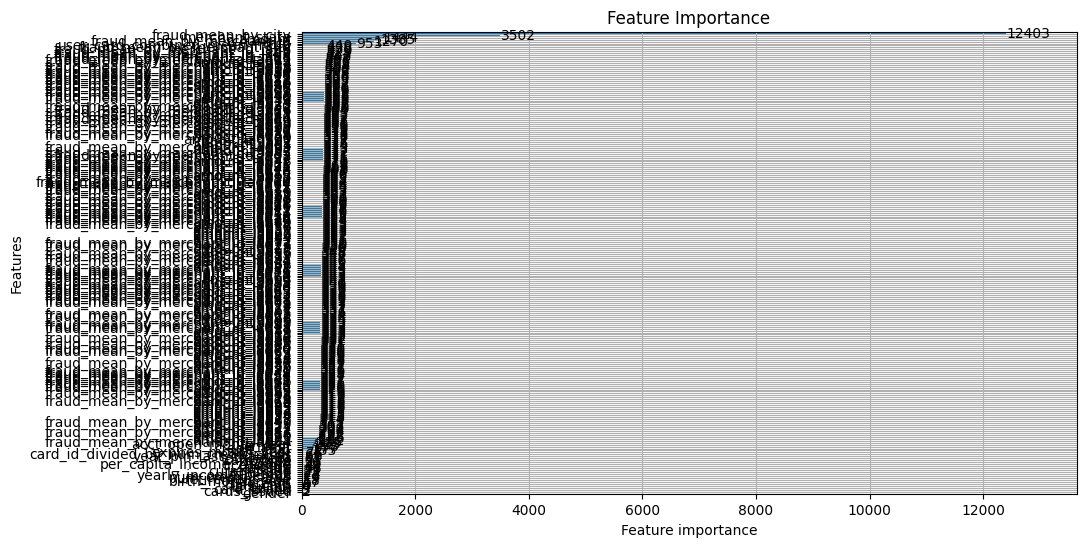

In [ ]:
# 特徴量の重要度をプロット
lgb.plot_importance(model, figsize=(10, 6), title="Feature Importance")

plt.show()

## undersampling + bagging

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import numpy as np

# バギングの回数を指定
num_bagging_iterations = 5
test_predictions = np.zeros(len(test_data))  # テストデータの予測を集約するための配列
val_predictions = np.zeros(94257)

# バギングループ
for iteration in range(num_bagging_iterations):
    # データセットの分割
    X = train_data.drop(['is_fraud?'], axis=1)
    y = train_data['is_fraud?']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # アンダーサンプリング
    fraud_data = X_train[y_train == 1]
    normal_data = X_train[y_train == 0]
    normal_data_resampled = resample(normal_data, n_samples=len(fraud_data))
    X_train_balanced = pd.concat([fraud_data, normal_data_resampled])
    y_train_balanced = pd.Series([1] * len(fraud_data) + [0] * len(normal_data_resampled))

    # LightGBMモデルの構築
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'verbose': -1
        # ハイパーパラメータ設定
    }

    train_dataset = lgb.Dataset(X_train_balanced, label=y_train_balanced)
    val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

    model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[val_dataset],
                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                                 lgb.log_evaluation(-1)]
                      )

    # テストデータの予測
    test_pred = model.predict(test_data, num_iteration=model.best_iteration)
    # 検証データの予測
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # 予測結果を集約
    test_predictions += test_pred
    val_predictions += val_pred

# バギング結果の平均を取る
test_predictions /= num_bagging_iterations
val_predictions /= num_bagging_iterations

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_predictions]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_7.csv', header=False, index=False)


# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_predictions]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.360171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.360104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	valid_0's binary_logloss: 0.360095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's binary_logloss: 0.360233
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's binary_logloss: 0.358792
Val F1 Score: 0.44013909587680083


# CatBoost

In [ ]:
# 特徴量とターゲットの分割
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# merchant_stateカラムのNaN値を文字列に変換
X_train['merchant_state'] = X_train['merchant_state'].astype(str)
X_val['merchant_state'] = X_val['merchant_state'].astype(str)

# zipカラムのNaN値を文字列に変換
X_train['zip'] = X_train['zip'].astype(str)
X_val['zip'] = X_val['zip'].astype(str)

# CatBoostモデルの構築
model = CatBoostClassifier(
    iterations=10000,  # num_boost_roundに対応
    loss_function='Logloss',  # binary_loglossに対応
    eval_metric='Logloss',  # binary_loglossに対応
    verbose=0  # verboseはCatBoostのハイパーパラメータに対応
)

# カテゴリカル変数の自動エンコーディング（事前処理が不要）
cat_features = [i for i, col in enumerate(X_train.columns) if col in categorical_columns]

# 訓練データをCatBoost用のデータセットに変換
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_dataset = Pool(X_train, label=y_train, cat_features=cat_features, weight=train_weight)

# 検証データをCatBoost用のデータセットに変換
val_dataset = Pool(X_val, label=y_val, cat_features=cat_features)

# モデルのトレーニング
model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=100, verbose_eval=True)

# モデルをファイルに保存
model.save_model('catboost_model.cbm')


# merchant_stateカラムのNaN値を文字列に変換
test_data['merchant_state'] = test_data['merchant_state'].astype(str)

# zipカラムのNaN値を文字列に変換
test_data['zip'] = test_data['zip'].astype(str)

# テストデータの予測
test_pred = model.predict(test_data, prediction_type='Probability')[:, 1]

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_pred]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_7.csv', header=False, index=False)


# 検証データの予測
val_pred = model.predict(X_val, prediction_type='Probability')[:, 1]

# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)